## Import Required Libraries
Running cell below will import the required libraries being used in the rest of the cells of this notebook

In [1]:
import cv2
import sys
import json
import time
import pickle 
import logging
import warnings
import numpy as np
import pandas as pd
import sys, os, importlib
from matplotlib import rc
from tqdm.auto import tqdm
from functools import partial
import matplotlib.pyplot as plt
from skimage.filters import gaussian
from scipy.ndimage import gaussian_filter
from skimage.segmentation import mark_boundaries
from pynvml import *
import torch
import torch.nn.functional as F
from torchvision import models
from torchvision import transforms
import timm
from datetime import datetime

rc('text',usetex=True)
rc('text.latex', preamble='\\usepackage{color}')
pd.set_option('display.max_columns', None)
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'
logging.getLogger('matplotlib').setLevel(level=logging.CRITICAL)
warnings.filterwarnings("ignore", category=DeprecationWarning)
import shap_bpt as shap_bpt
import chime
chime.theme('chime')

print('shap_bpt version :', shap_bpt.__version__)

shap_bpt version : 1.0


In [2]:
warnings.filterwarnings("ignore", message="Input Tensor 0 did not already require gradients, required_grads has been set automatically")
warnings.filterwarnings("ignore", message="Setting backward hooks on ReLU activations.The hooks will be removed after the attribution is finished")

os.environ['CUDA_LAUNCH_BLOCKING']="1"
os.environ['TORCH_USE_CUDA_DSA'] = "1"


In [3]:
use_cuda = torch.cuda.is_available()
# import torchvision
use_mps = ('mps' in dir(torch.backends)) and torch.backends.mps.is_available()
torch.manual_seed(12345)
device      = None

if   use_cuda:    device = torch.device("cuda")
elif use_mps:     device = torch.device("mps")
else:             device = torch.device("cpu")

print(f'Torch CUDA\t :\t {torch.cuda.is_available()}')
print(f'device\t\t   :\t {device}')

Torch CUDA	 :	 True
device		   :	 cuda


### DEFAULT PARAMS
Below cell contains the parameters switching between the prediction model, background replacement strategy, and other few parameters

In [4]:
# exp_no = 'E1'
# exp_no = 'E1_ViT'
exp_no = 'E2'  # IDEAL MODEL
# exp_no = 'E3'

USE_SOFTMAX= False

model_softmax = 'softmax' if USE_SOFTMAX else 'logits'

print(f'using exp: {exp_no } and model_softmax {model_softmax}')

using exp: E2 and model_softmax logits


In [5]:
from dataclasses import dataclass

@dataclass
class Parameters:
    dummy                   : bool  = False
    exp_no                  : str   = exp_no          
    model_type              : str   = ''
    pretrained_model_type   : str   = ''
    background_type         : str   = ''
params = Parameters()

In [6]:
def get_params_from_exp(params):
    if params.exp_no=='E1':
        params.model_type              = 'real'
        params.pretrained_model_type   = 'resnet'      
        params.background_type         = 'gray'
    if params.exp_no=='E1_ViT':
        params.model_type              = 'real'
        params.pretrained_model_type   = 'vit'      
        params.background_type         = 'gray'
    elif params.exp_no=='E2':
        params.model_type              = 'ideal'
        params.pretrained_model_type   = 'resnet'      
        params.background_type         = 'gray'
        params.file_name               = 'exp_E2'
    elif params.exp_no=='E3':
        params.model_type              = 'real'
        params.pretrained_model_type   = 'swin_trans_vit'      
        params.background_type         = 'gray'
    return params

params = get_params_from_exp(params)
params.file_name = f'exp_{params.exp_no}'


## Select model_type

In [7]:
# model_type       = 'real'   # Exp 1   
# model_type       = 'ideal'    # Exp 2

## Select pretrained_model_type

In [8]:
# pretrained_model_type           = 'resnet'                #   Exp 1,2,3
# pretrained_model_type           = 'swin_trans_vit'      #   Exp 4

## Select background_type

In [9]:
# background_type  = 'gray'     # Exp 1 and Exp 2
# background_type  = 'full'     # Exp 3
###############################################################################
# background_type  = 'black'     
# background_type  = 'white'     
# background_type  = 'noise'     
# background_type  = 'blurred'     


In [10]:
# if params.model_type =='ideal':
#     params.file_name = 'exp_E2'
# elif params.model_type =='real':
#     if params.pretrained_model_type=='resnet' and params.background_type=='gray':
#         params.file_name = 'exp_E1'
#     if params.pretrained_model_type=='swin_trans_vit':
#         params.file_name = 'exp_E5'
#     if params.background_type=='full':
#         params.file_name = 'exp_E3'
# if random_bpt:
#     file_name = 'exp_E3'

def get_exp_header():
    print('='*95)
    print('| ',f'{"MODEL_TYPE":15}','|',f'{"PRETRAINED_MODEL":22}','|',f'{"BACKGROUND_TYPE":22}','|',f'{"FILENAME":22}','|')
    print('-'*95)
    print('| ',f'{params.model_type:15}','|',f'{params.pretrained_model_type:22}','|',f'{params.background_type:22}','|',f'{params.file_name:22}','|')

get_exp_header()

|  MODEL_TYPE      | PRETRAINED_MODEL       | BACKGROUND_TYPE        | FILENAME               |
-----------------------------------------------------------------------------------------------
|  ideal           | resnet                 | gray                   | exp_E2                 |


In [11]:
num_explained_classes  =  1         # No of Top Predicted Classes
max_weight             =  None      # Hyperparameter for BPT and Axis-Aligned 

model_version          = 'v2'       # v1 , v2
# rel_pool_type          = 'sum_pos'  # required for -> relevance_mass_accuracy,relevance_rank_accuracy
suffix_full            = f'{params.model_type}_{params.background_type}'
batch_size             =  4 if params.pretrained_model_type  == 'swin_trans_vit' else 8 # Batch Size (depending on system resources), 2 or 4 If background_type=full 

### Paths Setting
This cell contains the setting of paths being used to load dataset, codes

In [12]:
submission_version    =  False

global path_seg_maps_raw,path_img_val,DS_name
path_codes    = os.getcwd()
path_notebook = os.path.abspath(os.path.join(os.getcwd(), os.pardir))

DS_name_annotation    = 'ImageNetS'
DS_name_img           = 'ImageNet'

# path_ds_main   = f'{path_notebook}/dataset'   if submission_version else 'D:\DS\ImageNet'
path_ds_main   = 'D:\DS\ImageNet'

if not submission_version:
    path_repos      = 'E:/PHD/datacloud_data/repos' 
    codes_local     = os.getcwd()
    
if submission_version:
    path_repos     = os.path.join(os.getcwd(),'utils')
    codes_local    = path_codes
sys.path.append(path_repos)
submission_version    =  True

path_utils    = os.path.abspath(os.path.join(path_notebook,'utils'))

path_seg_maps  = os.path.join(path_ds_main,f'{DS_name_annotation}/ILSVRC2012_img_val_S/ImageNetS50/validation-segmentation')
path_img_val   = os.path.join(path_ds_main,f'{DS_name_img}/ILSVRC2012_img_val')

filenames,files = [],[]
tagnames      = os.listdir(path_seg_maps)
for tn in tagnames:
    sub_dir = f'{path_seg_maps}//{tn}'
    filenames.extend(os.listdir(sub_dir))
    tempp = []
    for fn in os.listdir(sub_dir):
        tempp.append(f'{sub_dir}//{fn}')
    files.extend(tempp)

In [13]:
suffix                     = f'{params.pretrained_model_type}_{params.model_type}_{params.background_type}'

if submission_version:
    results_                   = os.path.join(os.getcwd(),'results')          # for submission
else:
    results_                   = os.path.join(codes_local,'results')
    
results_cloud                  = os.path.join(path_codes,'results')
results_path                   = os.path.join(results_,params.pretrained_model_type)

results_path                   = os.path.join(results_path,suffix)
results_path_single            = os.path.join(results_path      ,'single')
results_path_selected          = os.path.join(results_path      ,'selected')
plots_path                     = os.path.join(results_path,'plots')
plotsIoU_path                  = os.path.join(results_path,'plots_IoU')
vector_path                    = os.path.join(results_path,'vectors')
path_csv                       = os.path.join(results_,     'csv_logits')
results_path_fixed             = results_path

os.makedirs(results_path,              exist_ok=True)
os.makedirs(plots_path,                exist_ok=True)
os.makedirs(plotsIoU_path,             exist_ok=True)
os.makedirs(results_path_single,       exist_ok=True)
os.makedirs(results_path_selected,     exist_ok=True)
os.makedirs(vector_path,               exist_ok=True)

print('results_path\t\t',results_path)
print('results_path_single\t',results_path_single)
print('results_path_selected\t',results_path_selected)
print('-'*120)
print('Dataset path \t\t',path_ds_main)
print('-'*120)

print('path_csv\t\t',path_csv)

results_path		 e:\Cloud\RashidPHD\Supplimentary_Files\AAAI_26\notebooks\E1_E2_E3_E7\results\resnet\resnet_ideal_gray
results_path_single	 e:\Cloud\RashidPHD\Supplimentary_Files\AAAI_26\notebooks\E1_E2_E3_E7\results\resnet\resnet_ideal_gray\single
results_path_selected	 e:\Cloud\RashidPHD\Supplimentary_Files\AAAI_26\notebooks\E1_E2_E3_E7\results\resnet\resnet_ideal_gray\selected
------------------------------------------------------------------------------------------------------------------------
Dataset path 		 D:\DS\ImageNet
------------------------------------------------------------------------------------------------------------------------
path_csv		 e:\Cloud\RashidPHD\Supplimentary_Files\AAAI_26\notebooks\E1_E2_E3_E7\results\csv_logits


## BlackBox Model

In [14]:
from torchvision.models import resnet50, ResNet50_Weights
sys.path.append(f'{path_repos}/Transformer-Explainability')
from baselines.ViT.ViT_LRP import vit_base_patch16_224 as vit_LRP

model = None
def load_model():
    global model,model_version
    print(f'Model loaded\t:{params.pretrained_model_type}')
    # ------------- resnet 
    if params.pretrained_model_type=='resnet':
        model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V1 if model_version == 'v1' else ResNet50_Weights.IMAGENET1K_V2)
    ######################################################################################################
    # ------------- VIT 
    elif params.pretrained_model_type   == 'vit':
        # pass
        from torchvision.models import vit_b_16
        model = vit_b_16(weights='IMAGENET1K_V1')
        model = model.to(device)
    ######################################################################################################
    # ------------- vgg16 
    elif params.pretrained_model_type=='vgg16':
        model = models.vgg16(pretrained=True)
    ######################################################################################################
    # ------------- swin_trans_vit   
    elif params.pretrained_model_type=='swin_trans_vit':

        model = timm.create_model('swin_base_patch4_window7_224', pretrained=True)
    ######################################################################################################
    # ------------- vit_LRP 
    elif params.pretrained_model_type=='vit_LRP':
        model = vit_LRP(pretrained=True)
    # ------------- vit_base 
    elif params.pretrained_model_type=='vit_base':
        model = timm.create_model('vit_base_patch16_224', pretrained=True).to(device)
    # ------------- VIT 
    # elif params.pretrained_model_type =='':

        # from timm.models import swin_base_patch4_window7_224_in22k
        # from pytorch_grad_cam import GradCAMPlusPlus --> https://github.com/jacobgil/pytorch-grad-cam/issues/84
    
    model = model.to(device).eval()


##########################################################
mean = torch.tensor([0.485, 0.456, 0.406])
std = torch.tensor([0.229, 0.224, 0.225])
resnet50_preprocess = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize(mean=mean, std=std)]
)

load_model() # resnet         vit

Model loaded	:resnet


In [15]:
from torch.cuda.amp import autocast, GradScaler
# Forward function with mixed precision
# scaler = GradScaler()

if USE_SOFTMAX:
    print('Using Softmax')
    def f(x):
        ################### CHANGES
        # with autocast():
        return F.softmax(model(x), dim=1).cpu().detach().numpy()
else:
    print('NO Softmax')
    def f(x):
    ################### CHANGES
    # with autocast():
        return model(x).cpu().detach().numpy()

NO Softmax


In [16]:
with open(f'{path_utils}/imagenet_class_index.json') as file:
    CLS2IDX = json.load(file)
with open(f'{path_utils}/imagenet_class_index.json') as file:
    jf = json.load(file).values()
    class_names = [v[1] for v in jf]
    tag_to_classid = { v[0]:i for i,v in enumerate(jf) }

imagenetS_to_imagenet = {}
with open(f'{path_utils}/ImageNetS_categories_im50.txt') as file:
    for i,line in enumerate(file):
        imagenetS_to_imagenet[i+1] = tag_to_classid[line.strip()]
classid_to_tag= dict(zip(tag_to_classid.values(),tag_to_classid.keys()))

image_to_explain              = None
image_to_explain_preproc      = None
image_to_explain_tensor       = None
ground_truth                  = None

background_tensors            = None
background_image_set          = None
background_image_preproc_set  = None
weighted_ground_truth         = None
predicted_fS = sorted_classes = predicted_cls = predicted_f0 = f_S = f_0 = None

# Functions

### LOAD IMAGE AND CONVERT

In [17]:
def load_image(fname,loaded_image=False,bg_type=None):
    global path_img_val
    global image_to_explain, image_to_explain_preproc, image_to_explain_tensor
    # global predicted_fS, predicted_f0, predicted_cls, sorted_classes, f_S, f_0
    global ground_truth,weighted_ground_truth
    global model_type
    global background_tensors, background_image_set, background_image_preproc_set
    ground_truth = cv2.imread(f'{fname}', cv2.IMREAD_COLOR)[:,:,::-1]
    ground_truth = cv2.resize(ground_truth, [224,224], interpolation=cv2.INTER_NEAREST)
    ground_truth = ground_truth[:,:,0].astype(int) + 256*ground_truth[:,:,1].astype(int)
    ground_truth[ ground_truth==1000 ] = 0
    
    weighted_ground_truth = gaussian_filter(ground_truth.astype(float), 16) * ground_truth
    file_n = fname.split('//')[-1].split('.')[0]
    if not loaded_image:
        # Foreground image to be explained
        image_to_explain         = cv2.resize(cv2.imread(f'{path_img_val}/{file_n}.JPEG', cv2.IMREAD_COLOR),[224,224])[:,:,::-1]
    
    if params.model_type=='ideal':
        image_to_explain_preproc  = torch.ones(tuple(reversed(image_to_explain.shape)))
    else:
        image_to_explain_preproc  = resnet50_preprocess(image_to_explain.astype(np.float32)/255.0)
        
    image_to_explain_tensor = image_to_explain_preproc.to(device)
    np.random.seed(0)

    bkgnd0 = np.full_like(image_to_explain, 0)
    bkgnd1 = np.full_like(image_to_explain, 127)
    bkgnd2 = np.full_like(image_to_explain, 255)
    bkgnd3 = gaussian(image_to_explain, 8, channel_axis=-1)*255
    bkgnd4 = np.clip(np.random.normal(128, 128, size=image_to_explain.shape), 0, 255).astype(np.uint8)
    bkgnd4 = (gaussian(bkgnd4, 2.0, channel_axis=-1) * 255).astype(np.uint8)
    if bg_type=='black':
        background_image_set = np.array([bkgnd0])
    elif bg_type=='gray':
        background_image_set = np.array([bkgnd1])
    elif bg_type=='white':
        background_image_set = np.array([bkgnd2])
    elif bg_type=='blurred':
        background_image_set = np.array([bkgnd3])
    elif bg_type=='noise':
        background_image_set = np.array([bkgnd4])
    elif bg_type=='full':
        background_image_set = np.array([bkgnd0, bkgnd1, bkgnd2, bkgnd3, bkgnd4])
    if params.model_type=='ideal':
        background_image_preproc_set = [torch.zeros(tuple(reversed(bkgnd.shape)))
                                        for bkgnd in background_image_set]
    else:
        background_image_preproc_set = [resnet50_preprocess(bkgnd.astype(np.float32)/255.0)
                                        for bkgnd in background_image_set]

    background_tensors = torch.cat([torch.unsqueeze(bk_p, dim=0) 
                                    for bk_p in background_image_preproc_set]).to(device)

load_image(files[0], bg_type=params.background_type)

In [18]:
nvmlInit()
h = nvmlDeviceGetHandleByIndex(0)
def print_gpu_memory():
    info = nvmlDeviceGetMemoryInfo(h)
    print(f'total    : {info.total}')
    print(f'free     : {info.free}')
    print(f'used     : {info.used}')

### Masking Fucntion
Two Masking Function being used to generate Shapely values
- f_masked_resnet (pretrained model used for  Experiments E1)
- f_masked_ideal  (linear model used for Experiments E2) 

In [19]:
def f_masked_resnet(masks):
    global f, background_tensors, image_to_explain_tensor
    N,H,W = masks.shape
    B = background_tensors.shape[0]
    masks_tensor = torch.tensor(np.array(masks)).to(device)                     # N boolean masks with size W*H
    masks_tensor = torch.reshape(masks_tensor, (N,1,H,W))                       # N*H*W    -> N*1*H*W
    masks_tensor = torch.tile(masks_tensor, dims=(1,3,B,1)).reshape(B*N,3,H,W)  # N*1*H*W  -> NB*3*H*W
    Xf = torch.tile(image_to_explain_tensor, dims=(N*B,1,1,1))                  # 3*H*W    -> NB*3*H*W
    Xb = torch.tile(background_tensors, dims=(N,1,1,1))                         # 3*H*W    -> NB*3*H*W

    X = torch.where(masks_tensor, Xf, Xb) # T=Xf, F=Xb
    result = f(X)
    del X, Xb, Xf, masks_tensor
    result = result.reshape((-1, B, result.shape[1]))
    return np.mean(result, axis=1)
    
def f_masked_ideal(masks):
    global ground_truth,weighted_ground_truth
    res = []
    
    for m in masks:
        prob = np.sum(np.multiply(m, weighted_ground_truth)) / np.sum(weighted_ground_truth)
        # prob = 1.0 - math.exp(-prob)
        
        res.append(predicted_fS * prob) #np.tile(prob, reps=1000))
    res = np.array(res)
    return res
def f_masked(masks):
    global params
    return f_masked_resnet(masks) if params.model_type=='real' else f_masked_ideal(masks)
print(f'masking method : {f_masked.__name__}, model_type: {params.model_type}')

masking method : f_masked, model_type: ideal


In [20]:
def get_bg_values(f_masked,ground_truth,predicted_cls,class_names, verbose=False):
    global f_G, f_B
    # evaluate the ground truth mask with the background replacement strategy for masking function
    predicted_fG = f_masked(np.expand_dims(ground_truth, axis=0))[0]
    f_G = float(predicted_fG[predicted_cls])
    # print(class_names[predicted_cls], f_G, predicted_cls, f_G)
    # print('softmax prob:', np_softmax(predicted_fG)[predicted_cls])

    # evaluate the backgrounf (negative of the ground truth mask)
    background_mask = np.logical_not(ground_truth)
    predicted_fB = f_masked(np.expand_dims(background_mask, axis=0))[0]
    f_B = float(predicted_fB[predicted_cls])
    # print(class_names[predicted_cls], f_B, predicted_cls, f_B)
    # print('softmax prob:', np_softmax(predicted_fB)[predicted_cls])

    if verbose:
        print('nu(S):  ', round(f_S, 4))
        print('nu(G):  ', round(f_G, 4))
        print('nu(S/G):', round(f_B, 4))
        print('nu(0):  ', round(f_0, 4))
    return f_G, f_B

In [21]:
def load_image_to_explain(fname=None,loaded_image = False, bg_type=None):
    global predicted_fS, predicted_f0, predicted_cls, sorted_classes, f_S, f_0
    global model_type,pretrained_model_type

    global f_G, f_B
    if not loaded_image:
        load_image(fname,loaded_image=loaded_image,bg_type=bg_type)
    
    h,w,_ = image_to_explain.shape
    # Foreground image to be explained   
    predicted_fS = f(torch.unsqueeze(resnet50_preprocess(image_to_explain.astype(np.float32)/255.0).to(device), dim=0))[0]
    sorted_classes = np.flip(np.argsort(predicted_fS))
    predicted_cls = sorted_classes[0]
    f_S = float(predicted_fS[predicted_cls])
    #####################
    predicted_f0 = [f(torch.unsqueeze(resnet50_preprocess(bkgnd.astype(np.float32)/255.0).to(device), dim=0))[0] for bkgnd in background_image_set]
    predicted_f0 = np.mean(predicted_f0,axis=0)
    f_0          = float(predicted_f0[predicted_cls])
    f_G, f_B = get_bg_values(f_masked,ground_truth.astype(bool),predicted_cls,class_names)



In [22]:
# load_model(pretrained_model_type='vit') # resnet         vit
load_image_to_explain(fname =files[0] ,bg_type='gray')
# load_image(files[0], bg_type=background_type)
print(class_names[predicted_cls],f_S)
get_bg_values(f_masked,ground_truth.astype(bool),predicted_cls,class_names, verbose=True)

goldfish 7.596925258636475
nu(S):   7.5969
nu(G):   7.5969
nu(S/G): 0.0
nu(0):   0.6824


(7.596925258636475, 0.0)

### GT and IOU

In [23]:
def combine_groundtruth_explanation(gtruth, heatmap, threshold):
    if gtruth.ndim == 3:
        gt = gtruth[:,:,0]>0
    else:
        gt = gtruth[:,:]>0
    ht = (heatmap >= threshold).astype(np.uint8)
    img = np.zeros(shape=list(heatmap.shape)+[3], dtype=np.uint8)
    img[:,:,0] = 255*(1-gt)
    img[:,:,1] = 255*(1-ht)
    img[:,:,2] = 255*(1-ht)
    return img
def calc_IoU_curve(y_true, y_pred, add_noise=True):
    
    assert len(y_true.shape)==1 and len(y_pred.shape)==1 # assumes y_true and y_pred to be flattened arrays
    if add_noise:
        rng = np.random.default_rng(12345)
        # factor = np.mean(y_pred)/1000
        y_pred = y_pred + rng.normal(0.0, 0.000000001, size=y_pred.shape) # 0.0000001
    
    yd = np.array(sorted(zip(y_pred, y_true), reverse=True))
    X2   = np.zeros(len(y_pred))
    IoU2 = np.zeros(len(y_pred))
    Th   = np.zeros(len(y_pred))
    
    nT = np.sum(y_true)
    nInt = 0
    for i in range(len(y_pred)):
        if yd[i,1]: 
            nInt += 1
        
        IoU2[i] = nInt / (i + nT - nInt)
        X2[i] = i
        Th[i] = yd[i,0]
        
    X2 = X2 / len(y_pred)
    auc_IoU = 0
    for i in range(1, len(y_pred)):
        auc_IoU += (X2[i] - X2[i-1]) * (IoU2[i] + IoU2[i-1]) / 2.0
    
    best_pt = np.argmax(IoU2)
    
    if np.sum(y_pred) == 0:
        return X2, np.zeros_like(X2), Th[best_pt], X2[best_pt], 0
    else:
        return X2, IoU2, Th[best_pt], X2[best_pt], auc_IoU
        # return {'X':X2, 'Y':IoU2, 'max_IoU':Th[best_pt], 'x_best':X2[best_pt], 'auc_IoU':auc_IoU}

In [24]:
def vis_IoU(shapley_values, threshold, ground_truth,verbose=False):
    pred = shapley_values.flatten() >= threshold
    real = ground_truth.flatten()
    image = np.full((len(pred), 3), 1.0, dtype=np.float32)
    if verbose:
        print(np.sum(pred), np.sum(real))
    image[ pred & real, : ]    = (0.0, 0.0, 0.75) # True Positives
    image[ pred & (~real), : ] = (1.0, 0.6, 0.2)  # False Positives
    image[ (~pred) & real, : ] = (1.0, 0.4, 1.0)  # False Negatives

    return image.reshape(list(ground_truth.shape) + [3])

# Computer Scores

## SAL 2 AUC

In [25]:
def saliency_to_auc(nu, heatmap, f_S, f_0, predicted_cls, batch_size=4, method='del', num_samples=101, 
                    rule='trapezoid'):
    assert isinstance(heatmap, np.ndarray)
    assert len(heatmap.shape)==2 and np.issubdtype(heatmap.dtype, np.floating)

    # nu_max = max(f_S, f_0)
    # nu_min = min(f_S, f_0)

    xs, ys, ms, masks, qs = [], [], [], [], []
    for i, value in enumerate(np.linspace(start=1.0, stop=0.0, num=num_samples)):
        if method=='del':
            epsilon = (1 if value==0.0 else 0)
            q = (np.quantile(heatmap, q=value) - epsilon)
            m = heatmap <= q
            nx = (1.0 - np.sum(m) / m.size)
        elif method=='ins':
            epsilon = (1 if value==1.0 else 0)
            q = (np.quantile(heatmap, q=value) + epsilon)
            m = heatmap >= q
            nx = (np.sum(m) / m.size)
        else:
            raise Exception()
            
        # add a new datapoint on the curve
        if len(xs)==0 or nx != xs[-1]: 
            assert m.dtype==bool and len(m.shape)==2
            xs.append(nx)
            masks.append(m)
            ms.append(np.sum(heatmap[m]))
            qs.append(q)

        # evaluate the characteristic function
        if len(masks) >= batch_size or (len(masks)>0 and i==(num_samples-1)):
            y = nu(np.array(masks))[:, predicted_cls]
            ys.extend(y)
            masks = []

    assert len(masks)==0    
    xs, ys = np.array(xs), np.array(ys)
    assert(len(xs) == len(ys))

    # compute considering under/over shoots
    if f_S > f_0:
        overshoot_max = np.maximum(0, ys - f_S) # overshoot for values exceeding the maximum f(S)
        overshoot_min = np.maximum(0, f_0 - ys) # overshoot for values below the minimum f(0)
    else: # f(S) < f(0)
        overshoot_max = np.maximum(0, ys - f_0) # overshoot for values exceeding the maximum f(0)
        overshoot_min = np.maximum(0, f_S - ys) # overshoot for values below the minimum f(S)

    # clip ys, no oveshoots
    y_clipped = np.clip(ys, min(f_S, f_0), max(f_S, f_0))
    # adjust ys with the overshoot. Clip it inside the admitted range
    y_adjusted = np.clip(ys - 2*overshoot_max + 2*overshoot_min, min(f_S, f_0), max(f_S, f_0))

    # rebase to f(0)
    if f_S > f_0:
        flipped = False
        ys = ys - f_0 
        y_clipped = y_clipped - f_0 
        y_adjusted = y_adjusted - f_0
    else: # f(S) < f(0)
        flipped = True
        ys = f_0 - ys 
        y_clipped = f_0 - y_clipped 
        y_adjusted = f_0 - y_adjusted

    # rescaling
    ys_rescaled = ys / abs(f_S - f_0)
    y_clipped_rescaled = y_clipped / abs(f_S - f_0)
    y_adjusted_rescaled = y_adjusted / abs(f_S - f_0)

    auc, auc_r, auc_mae, auc_mse, auc_adj, auc_adjr, auc_clip, auc_clipr = 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0

    curve_range = range(1, len(xs)) if rule=='trapezoid' else range(len(xs))

    # compute the area under the curve with the midpoint Riemann sum (i.e. the trapezoidal rule)
    for i in curve_range:
        if rule=='trapezoid':
            delta_x = abs(xs[i] - xs[i-1])
            assert delta_x > 0
            y_mid   =         0.5*(ys[i-1] + ys[i])
            y_r_mid =         0.5*(ys_rescaled[i-1] + ys_rescaled[i])
            err_mid = y_mid - 0.5*(ms[i-1] - ms[i])
            y_clip_mid =       0.5*(y_clipped[i-1] + y_clipped[i])
            y_clipr_mid =      0.5*(y_clipped_rescaled[i-1] + y_clipped_rescaled[i])
            y_adj_mid =       0.5*(y_adjusted[i-1] + y_adjusted[i])
            y_adjr_mid =      0.5*(y_adjusted_rescaled[i-1] + y_adjusted_rescaled[i])
        else: # rectangles
            delta_x = 1.0/num_samples if i==len(xs)-1 else abs(xs[i+1] - xs[i])
            assert delta_x > 0
            y_mid   =         ys[i]
            y_r_mid =         ys_rescaled[i]
            err_mid = y_mid - ms[i]
            y_clip_mid =       y_clipped[i]
            y_clipr_mid =      y_clipped_rescaled[i]
            y_adj_mid =       y_adjusted[i]
            y_adjr_mid =      y_adjusted_rescaled[i]


        auc += abs(delta_x * y_mid) # base * height
        auc_r += abs(delta_x * y_r_mid) # base * height
        # auc_eff += abs(delta_x * err_mid) # base * height
        auc_mae += abs(delta_x * err_mid) # base * height
        auc_mse += abs(delta_x * (err_mid**2)) # base * height^2
        auc_clip += abs(delta_x * y_clip_mid)
        auc_clipr += abs(delta_x * y_clipr_mid)
        auc_adj += abs(delta_x * y_adj_mid)
        auc_adjr += abs(delta_x * y_adjr_mid)

    return {'xs':xs, 'ms':ms, 'qs':qs, 
            'f_0':f_0, 'f_S':f_S, 'flipped':flipped, 
            'ys':ys, 'ysr':ys_rescaled,
            'y_clip':y_clipped, 'y_clipr':y_clipped_rescaled, 
            'y_adj':y_adjusted, 'y_adjr':y_adjusted_rescaled, 
            'method':method, 'predicted_cls':predicted_cls,
            'auc':auc, 'auc_r':auc_r,
            'auc_mae':auc_mae, 'auc_mse':auc_mse, 'auc_rmse':np.sqrt(auc_mse), 
            'auc_clip':auc_clip, 'auc_clipr':auc_clipr,
            'auc_adj':auc_adj, 'auc_adjr':auc_adjr}

# XAI Methods

## 1. BPT

In [26]:
def get_bpt_heatmaps(num_samples=100,verbose=False):
    explainer = shap_bpt.Explainer(f_masked, image_to_explain, num_explained_classes=num_explained_classes, verbose=verbose)
    shap_values_bpt = explainer.explain_instance(num_samples, method='BPT',
                                             batch_size=batch_size, max_weight=max_weight)
    del explainer
    return shap_values_bpt

## 2. Axis-Aligned

In [27]:
def get_aa_heatmaps(num_samples=100,verbose=False):
    explainer = shap_bpt.Explainer(f_masked, image_to_explain, num_explained_classes=num_explained_classes, verbose=verbose)
    shap_values_aa = explainer.explain_instance(num_samples, method='AA', verbose_plot=False, 
                                                batch_size=batch_size, max_weight=max_weight)
    del explainer
    return shap_values_aa

## 3. SHAP

### Partition SHAP
 - https://shap-lrjball.readthedocs.io/en/latest/example_notebooks/partition_explainer/Partition.html

In [28]:
import shap as shap
# shap.logging.set_verbosity(shap.logging.WARNING)

def shap_predict(img):
    assert params.model_type=='real'
    return f(torch.Tensor(img).permute(0,3,1,2).to(device))

def get_pe_heatmaps(num_samples=1000):
    assert len(background_tensors)==1
    shapMasker     = shap.maskers.Image(background_tensors[0].permute(1,2,0).detach().cpu().numpy(), image_to_explain.shape)
    shapPartExpl   = shap.Explainer(shap_predict, shapMasker, output_names=class_names, algorithm="partition")
    shap_values_pe = shapPartExpl(np.expand_dims(image_to_explain_preproc.permute(1,2,0).detach().cpu().numpy(), 0), 
                                  max_evals=num_samples, batch_size=batch_size, 
                                  outputs=shap.Explanation.argsort.flip[:4],
                                  #show_progress=False, # -- VERIFY   ??????????
                                  )
    shap_values_pe = np.moveaxis(np.sum(shap_values_pe.values[0], axis=2), 2, 0)
    del shapMasker,shapPartExpl
    return shap_values_pe

### GradientExplainer SHAP
 - https://shap-lrjball.readthedocs.io/en/latest/generated/shap.GradientExplainer.html

In [29]:
def get_gradexpl_heatmap(use_abs=True):
    torch.cuda.empty_cache()
    if params.pretrained_model_type  == 'vit_LRP':
        return np.ones((1,224,224))
    
    e = shap.GradientExplainer(model, background_tensors)
    expl = e.shap_values(torch.unsqueeze(image_to_explain_tensor, dim=0),
                         nsamples=20, ranked_outputs=num_explained_classes)
    heatmaps = np.sum(expl[0], axis=1)[:,:,:,0]
    for i, clsid in enumerate(sorted_classes[:num_explained_classes]):
        if use_abs:
            heatmaps[i] = np.abs(heatmaps[i])
        heatmaps[i] = heatmaps[i] * (predicted_fS[clsid] - predicted_f0[clsid]) / np.sum(heatmaps[i])
        torch.cuda.empty_cache()
    del e,expl
    return heatmaps

### Captum
- https://captum.ai/tutorials/TorchVision_Interpret
- https://blog.paperspace.com/model-interpretability-and-understanding-for-pytorch-using-captum/

### SHAPGrad_Captum

In [30]:
# https://github.com/jacobgil/pytorch-grad-cam
# https://captum.ai/api/gradient_shap.html
from captum.attr import GradientShap
def get_gradshap_captum_heatmaps(n_samples=50):
    if params.pretrained_model_type == 'vit_LRP':
        gradient_shap = rand_img_dist = clsid = None
        return np.ones((1,224,224))
    torch.cuda.empty_cache()
    rand_img_dist = torch.cat([image_to_explain_tensor.unsqueeze(0) * 0, image_to_explain_tensor.unsqueeze(0) * 1])
    gradient_shap = GradientShap(model)
    
    heatmaps = []
    for clsid in sorted_classes[:num_explained_classes]:
        clsid = torch.tensor(clsid)
        
        heatmap = gradient_shap.attribute(image_to_explain_tensor.unsqueeze(0),
                                          n_samples=n_samples,
                                          stdevs=0.0001,
                                          baselines=rand_img_dist,
                                          target=clsid)
        heatmap = np.sum(heatmap.squeeze().cpu().detach().numpy(), axis=0)
        heatmap = np.abs(heatmap)
        heatmap = heatmap * (predicted_fS[clsid] - predicted_f0[clsid]) / np.sum(heatmap)
        heatmaps.append(heatmap)
        del heatmap
    torch.cuda.empty_cache()
    del gradient_shap,rand_img_dist,clsid
    return np.array(heatmaps)

## 4. LRP Captum

In [31]:
# LRP function
from captum.attr import LRP
def get_LRP_captum_heatmaps():
    lrp = LRP(model)
    
    heatmaps = []
    torch.cuda.empty_cache()
    for clsid in sorted_classes[:num_explained_classes]:
        clsid = torch.tensor(clsid).to(device)
        # print(clsid,class_names[clsid])
        heatmap = lrp.attribute(image_to_explain_tensor.unsqueeze(0),
                                target=clsid)
        heatmap = heatmap.squeeze().cpu().detach().numpy()
        heatmap = np.mean(heatmap, axis=0)
        heatmap = np.abs(heatmap)
        heatmap = heatmap * (predicted_fS[clsid] - predicted_f0[clsid]) / np.sum(heatmap)
        heatmaps.append(heatmap)
        del heatmap
    torch.cuda.empty_cache()
    del lrp,clsid
    return np.array(heatmaps)

### ViT-LRP
 - https://github.com/hila-chefer/Transformer-Explainability/blob/main/Transformer_explainability.ipynb

In [32]:
print(params.pretrained_model_type)
if params.pretrained_model_type  == 'vit_LRP': #or pretrained_model_type  == 'swin_trans_vit':
    sys.path.append(f'{path_repos}/Transformer-Explainability')
    
    from baselines.ViT.ViT_LRP import vit_base_patch16_224 as vit_LRP 
    #deit_base_patch16_224, vit_large_patch16_224
    from baselines.ViT.ViT_explanation_generator import LRP
    
    use_thresholding =  False#@param {type:"boolean"}
    
    sys.path.append(path_utils)
    import helper_functions_VT2 as hfvt
    import importlib
    
    importlib.reload(hfvt)
    CLS2IDX = hfvt.imgnet_cl()

resnet


In [33]:
print_gpu_memory()

total    : 8585740288
free     : 6554750976
used     : 2030989312


In [34]:
def get_heatmaps_LRP_ViT():
    torch.cuda.empty_cache()
    if params.pretrained_model_type  == 'swin_trans_vit'  or params.pretrained_model_type  == 'vit':
        return np.zeros((1,224,224))
        model_lrp = vit_LRP(pretrained=True).to(device)
        model_lrp.eval()
        attribution_generator = LRP(model)
    elif params.pretrained_model_type  == 'vit_LRP':
        attribution_generator = LRP(model)
    else:
        attribution_generator = LRP(model)
    
    heatmaps_lrp = []
    for clsid in sorted_classes[:num_explained_classes]:
        clsid = torch.tensor(clsid).to(device)
        
        transformer_attribution = attribution_generator.generate_LRP(image_to_explain_preproc.unsqueeze(0).cuda(), 
                                                                     method="transformer_attribution", 
                                                                     index=clsid).detach()
        transformer_attribution = transformer_attribution.reshape(1, 1, 14, 14)
        transformer_attribution = torch.nn.functional.interpolate(transformer_attribution, 
                                                                  scale_factor=16, 
                                                                  mode='bilinear')
        transformer_attribution = transformer_attribution.reshape(224, 224).data.cpu().numpy()
        transformer_attribution = (transformer_attribution - transformer_attribution.min()) / (transformer_attribution.max() - transformer_attribution.min())
    
        if use_thresholding:
          transformer_attribution = transformer_attribution * 255
          transformer_attribution = transformer_attribution.astype(np.uint8)
          ret, transformer_attribution = cv2.threshold(transformer_attribution, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
          transformer_attribution[transformer_attribution == 255] = 1
        heatmaps_lrp.append(transformer_attribution)
    torch.cuda.empty_cache()
    del clsid,transformer_attribution,attribution_generator
    return np.array(heatmaps_lrp)

In [35]:
load_image_to_explain(files[100], bg_type=params.background_type)

In [36]:
if params.pretrained_model_type  == 'swin_trans_vit' or params.pretrained_model_type  == 'vit':
    heatmaps_LRP = get_heatmaps_LRP_ViT()
    heatmap = heatmaps_LRP[0]
    vmax = np.quantile(heatmap, q=0.999)
    print('vmax',vmax)
    plt.subplot(121); plt.imshow(image_to_explain);
    plt.subplot(122); plt.imshow(heatmap, vmin = -vmax, vmax = vmax,cmap=shap_bpt.shapley_values_colormap); plt.show()

In [37]:
print_gpu_memory()

total    : 8585740288
free     : 6554750976
used     : 2030989312


## 5. LIME
 - https://github.com/marcotcr/lime

In [38]:
from lime import lime_image
from lime.wrappers.scikit_image import SegmentationAlgorithm
from skimage.segmentation import mark_boundaries

In [39]:
def format_lime_heatmaps(segments, expl):
    global predicted_fS, predicted_f0
    class_heatmaps = []
    for clsid in expl.top_labels:
        heatmap = np.zeros_like(segments, dtype=np.float32)
        for segm, importance in expl.local_exp[clsid]:
            heatmap[ segments==segm ] += importance 
        heatmap = heatmap * (predicted_fS[clsid] - predicted_f0[clsid]) / np.sum(heatmap)
        class_heatmaps.append(heatmap)
    return np.array(class_heatmaps)

In [40]:
def get_segment_number(image, md):
    segmentation_fn = SegmentationAlgorithm('quickshift', kernel_size=4, max_dist=md, ratio=0.2, random_seed=1234) 
    segments = segmentation_fn(image)
    return len(np.unique(segments))

def search_segment_number(image, target_seg_no, init_max_dist=100):
    lmd, rmd = 0, init_max_dist
    lsn = get_segment_number(image, lmd)
    rsn = get_segment_number(image, rmd)
    niter = 0
    while niter<40 and rsn!=target_seg_no:
        niter += 1
        mmd = (lmd + rmd) / 2.0
        msn = get_segment_number(image, mmd)
        if msn <= target_seg_no <= lsn:
            rsn, rmd = msn, mmd
        else:
            lsn, lmd = msn, mmd
    return rmd

In [41]:
def lime_predict(img):
    global model_type
    if params.model_type=='ideal':        
        return f_masked_ideal(torch.Tensor(img).permute(0,3,1,2).cpu().numpy() [:,0,:,:])
    else:
        return f(torch.Tensor(img).permute(0,3,1,2).to(device))
    
    # return f(torch.Tensor(img).permute(0,3,1,2).to(device))

def get_lime_heatmaps(num_segments=100, num_samples=1000, use_stratification=False,verbose=False):
    segmentation_fn = SegmentationAlgorithm('quickshift', kernel_size=4, 
                                            max_dist=search_segment_number(image_to_explain, num_segments), 
                                            ratio=0.2, random_seed=1234) 
                                            
    segments = segmentation_fn(image_to_explain)
    def segments_getter(img):
        return segments
    num_segments = len(np.unique(segments))
    heatmap_list = []
    for bg_c in background_image_preproc_set:
        torch.cuda.empty_cache()
        lime_explainer = lime_image.LimeImageExplainer(random_state=1234)
        lime_expl = lime_explainer.explain_instance(image_to_explain_preproc.permute(1,2,0).detach().numpy(), 
                                                    lime_predict,
                                                    top_labels=num_explained_classes,
                                                    # use_stratification=use_stratification,
                                                    segmentation_fn=segments_getter,
                                                    hide_color=bg_c.permute(1,2,0).detach().numpy(), 
                                                    num_samples=num_samples,
                                                    progress_bar=verbose
                                                    )
        if isinstance(lime_expl, tuple):
            lime_expl = lime_expl[2]
        heatmap_list.append(format_lime_heatmaps(segments, lime_expl))
        torch.cuda.empty_cache()
        del lime_expl,lime_explainer
    del segments
    return np.mean(heatmap_list, axis=0)

## 6. Integrated Decision Gradients (IDG)
 - https://github.com/chasewalker26/Integrated-Decision-Gradients/tree/main/util/attribution_methods

In [42]:
# https://arxiv.org/pdf/2305.20052.pdf
# https://github.com/chasewalker26/Integrated-Decision-Gradients/tree/main
sys.path.append(f'{path_repos}/Integrated-Decision-Gradients/util/attribution_methods')

from saliencyMethods import IDG
def get_idg_heatmaps(use_abs=True):
    # global predicted_fS, predicted_f0
    steps = 50
    batch_si = 25 # default 25
    baseline = 0
    heatmaps = []
    torch.cuda.empty_cache()
    for clsid in sorted_classes[:num_explained_classes]:
        heatmap = idg = IDG(torch.unsqueeze(image_to_explain_tensor, dim=0), model, 
                            steps, batch_si, baseline, device, predicted_cls)
        heatmap = idg.detach().cpu().numpy()
        heatmap = np.mean(heatmap, axis=0) # reduce to one attribution per pixel
        # normalize
        if use_abs:
            heatmap = np.abs(heatmap)
        # heatmap -= np.min(heatmap)
        heatmap = heatmap * (predicted_fS[clsid] - predicted_f0[clsid]) / np.sum(heatmap)
        heatmaps.append(heatmap)
        del heatmap
    torch.cuda.empty_cache()
    del steps,baseline,batch_si
    return np.array(heatmaps)

## 7. GradCAM
 - https://github.com/jacobgil/pytorch-grad-cam

In [43]:
# params.pretrained_model_type  == 'swin_trans_vit'

# import pytorch_grad_cam

# from pytorch_grad_cam import GradCAM, GradCAMPlusPlus, XGradCAM, EigenCAM, LayerCAM

### GradCAM for ViT

In [44]:
def vit_reshape_transform(tensor, height=14, width=14):
    result = tensor[:, 1:, :].reshape(tensor.size(0),
                                      height, width, tensor.size(2))

    # Bring the channels to the first dimension,
    # like in CNNs.
    result = result.transpose(2, 3).transpose(1, 2)
    return result


# def get_GradCAM_ViT(verbose=False):
#     if verbose:
#         print('RUNNING NEW GRADCAM FOR VIT')
    
#     target_layer = model.encoder.layers[-1].ln_1
#     # Initialize GradCAM

#     if verbose:
#         print(f'USING LAYER {target_layer}')
#     cam = GradCAM(model=model, target_layers=[target_layer], reshape_transform=vit_reshape_transform)
#     image_to_explain_tensor_4d = torch.unsqueeze(image_to_explain_preproc, dim=0). to(device)

#     # Predict
#     target_category = torch.argmax(model(image_to_explain_tensor_4d)).item()

#     print('target_category', target_category)
#     # Generate CAM
#     grayscale_cam = cam(input_tensor=image_to_explain_tensor_4d,
#                         targets=[ClassifierOutputTarget(target_category)])

#     print('grayscale_cam', grayscale_cam.shape)

#     grayscale_cam = grayscale_cam[0, :]
#     return grayscale_cam


from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

# GradCAM function
def get_gradcam_heatmaps_for_vit(verbose = False):
    global model
    # print('get_gradcam_heatmaps_for_swin_vit')
    global predicted_fS, predicted_f0
    # target_layers =  [model.layers[-1].blocks[-1].norm1]
    if verbose:
        print('RUNNING NEW GRADCAM FOR VIT')
    
    target_layers = [model.encoder.layers[-1].ln_1]

    cam = GradCAM(model=model, 
                  target_layers=target_layers,
                  reshape_transform=vit_reshape_transform)
    heatmaps = []
    for clsid in sorted_classes[:num_explained_classes]:
        heatmap = cam(input_tensor=torch.unsqueeze(image_to_explain_tensor, dim=0), 
                      targets=[ClassifierOutputTarget(clsid)])[0]
        # normalize
        # heatmap -= np.mean(heatmap)
        heatmap = heatmap * (predicted_fS[clsid] - predicted_f0[clsid]) / np.sum(heatmap)
        heatmaps.append(heatmap)
        del heatmap
    del cam,clsid
    return np.array(heatmaps)


# grayscale_cam = get_GradCAM_ViT()
# cam_image = show_cam_on_image(image_to_explain / 255.0, grayscale_cam, use_rgb=True)

# plt.imshow(cam_image)
# plt.axis('off')
# plt.title("Grad-CAM on ViT-B/16")
# plt.show()

In [45]:
# model.layers[-1].blocks[-1].norm1

In [46]:
# from captum.attr import GuidedGradCam
# def get_gradcam_vit_heatmaps(num_explained_classes=4):

#     print('CALLING THIS FUNCTION', get_gradcam_vit_heatmaps, ' for -->', params.pretrained_model_type)
#     if params.pretrained_model_type  == 'vit_LRP':
#         return np.zeros((num_explained_classes,224,224))
#     # elif params.pretrained_model_type  == 'swin_trans_vit':
#     #     return np.zeros((num_explained_classes,224,224))
#         # return np.full((1,224,224), 1)
#     # target_layer = model.norm

#     # target_layers = [model.blocks[-1].attn]
#     # target_layer = model.encoder.ln   # FOR VIT
#     target_layer = [model.norm1]
#     target_layer = model.head
#     # print('target_layer', target_layer)
#     # target_layer = model.blocks[-1]#.norm2  # Typically, the last layer norm after the attention block
    
#     guided_gc = GuidedGradCam(model, target_layer)

#     # print(guided_gc)
#     heatmaps = []
#     torch.cuda.empty_cache()
#     for clsid in sorted_classes[:num_explained_classes]:
        
#         attribution = guided_gc.attribute(torch.unsqueeze(image_to_explain_tensor, dim=0), 3)
#         print('attribution', attribution.shape, attribution.dtype)

#         # print(attribution.shape)
#         heatmap = np.sum(attribution.squeeze().cpu().detach().numpy(), axis=0)

#         print('heatmap', heatmap)
#         heatmap = np.abs(heatmap)
#         print(clsid, np.sum(heatmap))
#         heatmap = heatmap * (predicted_fS[clsid] - predicted_f0[clsid]) / np.sum(heatmap)
#         heatmaps.append(heatmap)
#         del heatmap,attribution
#     torch.cuda.empty_cache()
#     del clsid,guided_gc,target_layer
#     return np.array(heatmaps)
# get_gradcam_vit_heatmaps(num_explained_classes=4)

In [47]:
# [model.encoder.layers[-1].self_attention]

In [48]:
if params.pretrained_model_type  == 'swin_trans_vit':
    heatmap = get_gradcam_vit_heatmaps()[0]
    print('heatmap shape:', heatmap.shape)
    # print(get_gradcam_vit_heatmaps().shape)
    plt.imshow(image_to_explain); plt.show()
    print(predicted_cls)
    vm = np.quantile(np.abs(heatmap), q=0.99)
    plt.imshow(heatmap, vmin = -vm, vmax = vm, cmap= shap_bpt.shapley_values_colormap)

if params.pretrained_model_type  == 'vit':
    heatmap = get_gradcam_heatmaps_for_vit()[0]
    print('heatmap shape:', heatmap.shape)
    # print(get_gradcam_vit_heatmaps().shape)
    plt.imshow(image_to_explain); plt.show()
    print(predicted_cls)
    vm = np.quantile(np.abs(heatmap), q=0.99)
    plt.imshow(heatmap, vmin = -vm, vmax = vm, cmap= shap_bpt.shapley_values_colormap)

In [49]:
params.pretrained_model_type

'resnet'

In [50]:
# https://github.com/jacobgil/pytorch-grad-cam
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget

if params.pretrained_model_type != 'swin_trans_vit':
    if params.pretrained_model_type == 'vgg16':
        target_layers = [model.features[-1]]
    elif params.pretrained_model_type == 'vit_LRP':
        target_layers = [model.blocks[-1].attn]
    # if :
    #     target_layers = [model.layer4[-1]]
        # pass
        # target_layers = [model.encoder.layers[-1].self_attention]
elif params.pretrained_model_type == 'vit':
    target_layers = [model.encoder.layers[-1].self_attention]
# GradCAM function
def get_gradcam_heatmaps():
    global predicted_fS, predicted_f0
    
    cam = GradCAM(model=model.to(device), 
                  target_layers=target_layers)
    heatmaps = []
    for clsid in sorted_classes[:num_explained_classes]:
        heatmap = cam(input_tensor=torch.unsqueeze(image_to_explain_tensor, dim=0), 
                      targets=[ClassifierOutputTarget(clsid)])[0]
        # normalize
        # heatmap -= np.mean(heatmap)
        heatmap = heatmap * (predicted_fS[clsid] - predicted_f0[clsid]) / np.sum(heatmap)
        heatmaps.append(heatmap)
        del heatmap
    del cam,clsid
    return np.array(heatmaps)

In [51]:
# https://github.com/jacobgil/pytorch-grad-cam
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget

if params.pretrained_model_type != 'swin_trans_vit':
    if params.pretrained_model_type == 'vgg16':
        target_layers = [model.features[-1]]
    elif params.pretrained_model_type == 'vit_LRP':
        target_layers = [model.blocks[-1].attn]

        
    else:
        pass
        # target_layers = [model.blocks[-1].attn]
        # target_layers = [model.encoder.layers[-1].self_attention]
if  params.pretrained_model_type == 'vit':
    target_layers = [model.encoder.layers[-1].self_attention]


def swinT_reshape_transform(tensor, height=7, width=7):
    result = tensor.reshape(tensor.size(0),
                            height, width, tensor.size(2))

    # Bring the channels to the first dimension,
    # like in CNNs.
    result = result.transpose(2, 3).transpose(1, 2)
    return result


def vit_reshape_transform(tensor, height=14, width=14):
    result = tensor[:, 1:, :].reshape(tensor.size(0),
                                      height, width, tensor.size(2))

    # Bring the channels to the first dimension,
    # like in CNNs.
    result = result.transpose(2, 3).transpose(1, 2)
    return result


# GradCAM function
def get_gradcam_heatmaps_for_swin_vit():
    global model
    # print('get_gradcam_heatmaps_for_swin_vit')
    global predicted_fS, predicted_f0
    target_layers =  [model.layers[-1].blocks[-1].norm1]
    
    def reshape_transform(tensor, height=7, width=7):
        result = tensor.reshape(tensor.size(0),
            height, width, tensor.size(2))

        # Bring the channels to the first dimension,
        # like in CNNs.
        result = result.transpose(2, 3).transpose(1, 2)
        return result

    cam = GradCAM(model=model, 
                  target_layers=target_layers,
                  reshape_transform=reshape_transform)
    heatmaps = []
    for clsid in sorted_classes[:num_explained_classes]:
        heatmap = cam(input_tensor=torch.unsqueeze(image_to_explain_tensor, dim=0), 
                      targets=[ClassifierOutputTarget(clsid)])[0]
        # normalize
        # heatmap -= np.mean(heatmap)
        heatmap = heatmap * (predicted_fS[clsid] - predicted_f0[clsid]) / np.sum(heatmap)
        heatmaps.append(heatmap)
        del heatmap
    del cam,clsid
    return np.array(heatmaps)


# plt.imshow(get_gradcam_heatmaps_for_swin_vit(model)[0])

In [52]:
load_image_to_explain(files[0], bg_type=params.background_type)

In [53]:
# if params.pretrained_model_type  != 'swin_trans_vit' and params.pretrained_model_type  != 'vit_LRP' and params.pretrained_model_type  != 'vit':
#     heatmap = get_gradcam_heatmaps()[0]
#     plt.imshow(image_to_explain); plt.show()
#     plt.imshow(heatmap)

In [54]:
get_exp_header()

|  MODEL_TYPE      | PRETRAINED_MODEL       | BACKGROUND_TYPE        | FILENAME               |
-----------------------------------------------------------------------------------------------
|  ideal           | resnet                 | gray                   | exp_E2                 |


# Combining All Functions

In [55]:
params.pretrained_model_type

'resnet'

In [56]:
#     name,                 color,                  functor
verbose = False
# if pretrained_model_type  == 'swin_trans_vit':
#     verbose = True


varaion_range = list(range(100,2100,100))


methods = [
    (f'BPT-{vr}', 'xkcd:bright blue', partial(get_bpt_heatmaps, num_samples=vr, verbose=verbose))
    for vr in varaion_range
]



# methods = [
#     ('BPT-100',         'xkcd:light pink',     partial(get_bpt_heatmaps, num_samples=100,verbose=verbose)),
#     ('BPT-500',         'xkcd:bright pink',     partial(get_bpt_heatmaps, num_samples=500,verbose=verbose)),
#     ('BPT-1000',         'xkcd:deep pink',     partial(get_bpt_heatmaps, num_samples=1000,verbose=verbose)),
#     ]
# methods_pe = [ # if single background
#     ('Partition-100',   'xkcd:bluish',     partial(get_pe_heatmaps, num_samples=100)),
#     ('Partition-500',   'xkcd:cerulean',   partial(get_pe_heatmaps, num_samples=500)),
#     ('Partition-1000',   'xkcd:soft blue', partial(get_pe_heatmaps, num_samples=1000))
#     ]


# methods_aa = [ # if multiple backgrounds
#     ('AA-100', 'xkcd:bright blue',     partial(get_aa_heatmaps, num_samples=100, verbose=verbose)),
#     ('AA-500', 'xkcd:bright blue',     partial(get_aa_heatmaps, num_samples=500, verbose=verbose)),
#     ('AA-1000', 'xkcd:bright blue',    partial(get_aa_heatmaps, num_samples=1000, verbose=verbose)),
# ]

methods_aa = [
    (f'AA-{vr}', 'xkcd:bright blue', partial(get_aa_heatmaps, num_samples=vr, verbose=verbose))
    for vr in varaion_range
]


# methods_aa_huge = [
#     ('AA-5000', 'xkcd:bright blue',      partial(get_aa_heatmaps, num_samples=5000, verbose=verbose)),
#     ('AA-10000', 'xkcd:bright blue',     partial(get_aa_heatmaps, num_samples=10000, verbose=verbose)),
# ]
methods_lime = [
    ('LIME-100',        'xkcd:bright lime',     partial(get_lime_heatmaps, num_segments=100/5, num_samples=100,verbose=verbose)),
    ('LIME-500',        'xkcd:kermit green',   partial(get_lime_heatmaps, num_segments=500/5, num_samples=500,verbose=verbose)),
    ('LIME-1000',        'xkcd:dark lime green',partial(get_lime_heatmaps, num_segments=1000/5, num_samples=1000,verbose=verbose))
    ]

# methods_cam = [
#     ('aIDG',         'xkcd:indigo',          partial(get_idg_heatmaps, use_abs=True)),
#     ('aGradExpl',    'red',                  partial(get_gradexpl_heatmap, use_abs=True))
#     ]

# methods_ShapGradE = [
#     ('ShapGradE',     'xkcd:camel',            partial(get_gradshap_captum_heatmaps, n_samples=20)),    
# ]

# # methods_limeSAM = [
# #     ('LIMESAM',        'xkcd:bright lime',     partial(get_limeSAM_heatmaps, num_samples=500, verbose=verbose)),
# #     ]



# methods_LRP_ViT = [
#         ('LRP',        'xkcd:bright lime',     get_heatmaps_LRP_ViT),
    
#     ]
# methods_LRP = [
#     ('LRP',        'xkcd:bright lime',     get_LRP_captum_heatmaps),
    
#     ]

# method_gradcam_vit_heatmaps = [
#     ('GradCAM',     'xkcd:camel',            get_gradcam_heatmaps_for_swin_vit), #get_gradcam_vit_heatmaps),
#     ]

# if params.pretrained_model_type == 'vit_LRP':
#     methods_gradcam = [
#     ('GradCAM',     'xkcd:camel',            get_gradcam_vit_heatmaps),
#     ]
# elif params.pretrained_model_type == 'vit':
#     methods_gradcam = [
#     ('GradCAM',     'xkcd:camel',            get_gradcam_heatmaps_for_vit),
#     ]

# else:
#     methods_gradcam = [
#     ('GradCAM',     'xkcd:camel',            get_gradcam_heatmaps),
    # ]
    

methods += methods_aa #methods_pe if len(background_tensors) == 1 and params.model_type!='ideal' else methods_aa
# if params.model_type == 'ideal':
#     methods += methods_aa_huge

# methods += methods_lime
# methods += methods_limeSAM
######## CAM   #############    
# if pretrained_model_type  != 'swin_trans_vit' :

# if params.pretrained_model_type  == 'swin_trans_vit' or params.pretrained_model_type == 'vit_LRP' and \
#                          params.pretrained_model_type  != 'vit'\
#       and params.model_type != 'ideal':
#     methods += methods_LRP_ViT

# else:
#     if params.model_type != 'ideal':
#         methods += methods_LRP


# if params.pretrained_model_type  == 'vit' or params.pretrained_model_type  == 'swin_trans_vit':
#     methods += methods_LRP_ViT
# else:
    

# if params.pretrained_model_type  == 'swin_trans_vit' or params.pretrained_model_type == 'vit_LRP' and params.model_type != 'ideal':
#     methods += method_gradcam_vit_heatmaps
# else:
#     if params.model_type != 'ideal':
#         methods += methods_gradcam

# if params.model_type != 'ideal':
#     methods += methods_cam
# if params.model_type != 'ideal':
#     methods += methods_ShapGradE

for n,_,functt in methods:
    print(n, functt)

BPT-100 functools.partial(<function get_bpt_heatmaps at 0x000001DCB24B7B80>, num_samples=100, verbose=False)
BPT-200 functools.partial(<function get_bpt_heatmaps at 0x000001DCB24B7B80>, num_samples=200, verbose=False)
BPT-300 functools.partial(<function get_bpt_heatmaps at 0x000001DCB24B7B80>, num_samples=300, verbose=False)
BPT-400 functools.partial(<function get_bpt_heatmaps at 0x000001DCB24B7B80>, num_samples=400, verbose=False)
BPT-500 functools.partial(<function get_bpt_heatmaps at 0x000001DCB24B7B80>, num_samples=500, verbose=False)
BPT-600 functools.partial(<function get_bpt_heatmaps at 0x000001DCB24B7B80>, num_samples=600, verbose=False)
BPT-700 functools.partial(<function get_bpt_heatmaps at 0x000001DCB24B7B80>, num_samples=700, verbose=False)
BPT-800 functools.partial(<function get_bpt_heatmaps at 0x000001DCB24B7B80>, num_samples=800, verbose=False)
BPT-900 functools.partial(<function get_bpt_heatmaps at 0x000001DCB24B7B80>, num_samples=900, verbose=False)
BPT-1000 functools.

In [57]:
get_exp_header()

|  MODEL_TYPE      | PRETRAINED_MODEL       | BACKGROUND_TYPE        | FILENAME               |
-----------------------------------------------------------------------------------------------
|  ideal           | resnet                 | gray                   | exp_E2                 |


# Functions Plotting


In [58]:
def fun_plot_heatmaps(heatmaps,methods_,path=None,title = None,plot_title=False,fontsize=14,plot_colorbar=False,save_fig=True,selected_ext='svg',dpi=200,transparent=True,destroy_fig=True):
    fig,axes = plt.subplots(1, len(methods_)+2, figsize=(2*(len(methods_)+2), 2))
    axes[0].imshow(image_to_explain)
    axes[0].set_xticks([]) ; axes[0].set_yticks([])
    axes[1].imshow(ground_truth, cmap='binary')
    axes[1].set_xticks([]) ; axes[1].set_yticks([])
    if plot_title:
        axes[0].set_title('Input', fontsize=fontsize)
        axes[1].set_title('GT', fontsize=fontsize)

    for ii, (n,c,_) in enumerate(methods_):
        ax = axes[ii+2]
        vmax = np.quantile(np.abs(heatmaps[n][0]), 0.99)
        ax.imshow(heatmaps[n][0], cmap=shap_bpt.shapley_values_colormap, vmin=-vmax, vmax=vmax)
        # ax.imshow(heatmaps[n][0], cmap=shap_bpt.colormap_default, vmin=-vmax, vmax=vmax)
        
        marked_h = mark_boundaries(np.tile((255,255,255,0), (heatmaps[n][0].shape[0],heatmaps[n][0].shape[1],1)), ground_truth, 
                             mode='thick', color=(0,0,0,1))
        ax.imshow(marked_h)
        ax.set_xticks([]) ; ax.set_yticks([])
        if plot_title:
            ax.set_title(n, fontsize=fontsize)
    plt.subplots_adjust(wspace=0.05,hspace=0.05)
    # plt.tight_layout(pad = 0.1)
    
    if save_fig:
        if title is None:
            suffix = f'{image_n}_{params.background_type}_heatmap.{selected_ext}'
        else:
            suffix = f'{image_n}_{params.background_type}_heatmap_{title}.{selected_ext}'
            # print('saving at',path)                                        
        plt.savefig(f'{path}//{suffix}',dpi=200,transparent=True,bbox_inches='tight', pad_inches=0.02)
    if destroy_fig:
        plt.close(fig)
    plt.show()
    del vmax,marked_h

### FUNC: fun_plot_IoU

In [59]:
props         = dict(boxstyle='round', facecolor='white', alpha=0.6, pad=0.2)
def fun_plot_IoU(heatmaps,IoU,methods_,path=None,title = None,plot_title=False,fontsize=14,save_fig=True,selected_ext='svg',dpi=200,transparent=True,destroy_fig=True):
    fig,axs = plt.subplots(1,  len(methods_)+2, figsize=(2*(len(methods_)+2), 2))
    axs[0].imshow(image_to_explain)
    axs[0].set_xticks([]) ; axs[0].set_yticks([])
    axs[1].imshow(ground_truth, cmap='binary')
    axs[1].set_xticks([]) ; axs[1].set_yticks([])
    if plot_title:
        axs[0].set_title('input', fontsize=fontsize)
        axs[1].set_title('GT', fontsize=fontsize)
    
    # n = 'BPT-100'
    # img, max_IoU = vis_IoU(heatmaps[n][0], IoU[n][2], ground_truth), np.max(IoU[n][1])
    # plt.imshow(img)
    # return
    for ii, (n,_,_) in tqdm(enumerate(methods_), desc='IoU',leave=False):
        ax = axs[ii+2]
        img, max_IoU = vis_IoU(heatmaps[n][0], IoU[n][2], ground_truth), np.max(IoU[n][1])
        # print(img)
        ax.imshow(img)
        ax.text(11,47, f'IoU:{max_IoU:.3}', fontsize=24, bbox=props,weight='bold')
        ax.set_xticks([]); ax.set_yticks([])
        if plot_title:
            ax.set_title(n, fontsize=fontsize)
    plt.subplots_adjust(wspace=0.05,hspace=0.05)
    # plt.tight_layout(pad = 0.1)
    if save_fig:
        if title is None:
            suffix = f'{image_n}_{params.background_type}_IoU.{selected_ext}'
        else:
            suffix = f'{image_n}_{params.background_type}_IoU_{title}.{selected_ext}'

        plt.savefig(f'{path}//{suffix}',dpi=dpi,transparent=transparent,bbox_inches='tight', pad_inches=0.02)
    if destroy_fig:
        plt.close(fig)
    plt.show()
    del img,max_IoU

In [60]:
from matplotlib import rc
rc('text',usetex=True)
rc('text.latex', preamble='\\usepackage{color}')

def fun_plot_performance(aucI, aucD, IoU,
                         list_variants=['BPT-100', 'AA-100', 'LIME-100'],
                         budget_set='100',
                         path=None,
                         file_name='',
                         save_fig=True,
                         fontsize=14,
                         set_title=False,
                         plot_lime=False,
                         ttl=None,
                         layout='row'  # 'row' or '2rows'
                         ):
    import numpy as np
    import matplotlib.pyplot as plt

    # Order of plots (grouped by column for 2-row layout)
    plot_defs = [
        {'title': '$\\mathit{AUC}^{+}$',         'typee': 'auc',        'from': 'aucI'}, # 0
        {'title': '$\\mathit{AUC}^{-}$',         'typee': 'auc',        'from': 'aucD'}, # 1
        {'title': '$\\mathit{AUC}^{+}-clip$',     'typee': 'auc_clip',   'from': 'aucI'}, # 2
        {'title': '$\\mathit{AUC}^{-}-clip$',     'typee': 'auc_clip',   'from': 'aucD'}, # 3
        {'title': '$\\mathit{AUC^{+}-Adj}$',     'typee': 'auc_adj',    'from': 'aucI'}, # 4
        {'title': '$\\mathit{AUC^{-}-Adj}$',     'typee': 'auc_adj',    'from': 'aucD'}, # 5
        
        {'title': '$\\mathit{AU}{\!-\!}\\mathit{IoU}$', 'typee': 'auc_iou', 'from': 'iou'}, # 6 
        #####################################################################

        {'title': '$\\mathit{AUC}^{+}-r$',       'typee': 'auc_r',      'from': 'aucI'}, # 7
        {'title': '$\\mathit{AUC}^{-}-r$',       'typee': 'auc_r',      'from': 'aucD'}, # 8
        {'title': '$\\mathit{AUC}^{+}-clip-r$', 'typee': 'auc_clip_r', 'from': 'aucI'}, # 9
        {'title': '$\\mathit{AUC}^{-}-clip-r$', 'typee': 'auc_clip_r', 'from': 'aucD'}, # 10
        {'title': '$\\mathit{AUC^{+}-Adj-r}$',   'typee': 'auc_adj_r',  'from': 'aucI'}, # 11
        {'title': '$\\mathit{AUC^{-}-Adj-r}$',   'typee': 'auc_adj_r',  'from': 'aucD'}, # 12 
        
    ]
    save_version = list_variants[0].split('-')[-1]
    # Reorder plot_defs for 2-row layout: interleaved columns
    if layout == '2rows':
        top = plot_defs[0::2]
        bottom = plot_defs[1::2]
        plot_defs = [None]*(len(top)+len(bottom))
        plot_defs[::2] = top
        plot_defs[1::2] = bottom

    total_variant = len(plot_defs)

    # Layout config
    if layout == 'row':
        nrows, ncols = 1, total_variant
        fig_width, fig_height = 25, 2.5
    elif layout == '2rows':
        nrows, ncols = 2, int(np.ceil(total_variant / 2))
        fig_width, fig_height = 16, 5
    else:
        raise ValueError("layout must be either 'row' or '2rows'")

    fig, axes = plt.subplots(nrows, ncols, figsize=(fig_width, fig_height))
    axes = axes.flatten()

    # Alias
    aucI_aa = aucI[list_variants[0]]
    aucD_aa = aucD[list_variants[0]]
    auc_IoU_aa = IoU[list_variants[0]]

    aucI_bpt = aucI[list_variants[1]]
    aucD_bpt = aucD[list_variants[1]]
    auc_IoU_bpt = IoU[list_variants[1]]
    if len(list_variants)==3:
        aucI_lime = aucI[list_variants[2]]
        aucD_lime = aucD[list_variants[2]]
        auc_IoU_lime = IoU[list_variants[2]]

    def get_params_auc(auc_, typee):
        return {
            'auc':        (auc_['xs'], auc_['ys'],     auc_['ms'], auc_['auc']),
            'auc_r':      (auc_['xs'], auc_['ysr'],    auc_['ms'], auc_['auc_r']),
            'auc_adj':    (auc_['xs'], auc_['y_adj'],  auc_['ms'], auc_['auc_adj']),
            'auc_adj_r':  (auc_['xs'], auc_['y_adjr'], auc_['ms'], auc_['auc_adjr']),
            'auc_clip':   (auc_['xs'], auc_['y_clip'], auc_['ms'], auc_['auc_clip']),
            'auc_clip_r': (auc_['xs'], auc_['y_clipr'],auc_['ms'], auc_['auc_clipr']),
        }.get(typee, (None, None, None, None))

    def get_params_iou(iou_, typee):
        if typee == 'auc_iou':

            # xmb, ymb = iou_[3], np.max(iou_[1])


            Xa, Ya, Ma, La = iou_[0], iou_[1], None, iou_[4]
            xma, yma = iou_[3], np.max(iou_[1])
            return Xa, Ya, Ma, La, xma, yma
        return None, None, None, None, None, None

    for i, config in enumerate(plot_defs):
        ax = axes[i]
        title = config['title']
        typee = config['typee']
        source = config['from']

        # Select correct dict
        if source == 'aucI':
            Xa, Ya, Ma, La = get_params_auc(aucI_aa, typee)
            Xb, Yb, Mb, Lb = get_params_auc(aucI_bpt, typee)
            if len(list_variants)==3:
                Xl, Yl, Ml, Ll = get_params_auc(aucI_lime, typee)
        elif source == 'aucD':
            Xa, Ya, Ma, La = get_params_auc(aucD_aa, typee)
            Xb, Yb, Mb, Lb = get_params_auc(aucD_bpt, typee)
            if len(list_variants)==3:
                Xl, Yl, Ml, Ll = get_params_auc(aucD_lime, typee)
        elif source == 'iou':
            Xa, Ya, Ma, La, xma, yma = get_params_iou(auc_IoU_aa,  typee)
            Xb, Yb, Mb, Lb, xmb, ymb = get_params_iou(auc_IoU_bpt, typee)
            if len(list_variants)==3:
                Xl, Yl, Ml, Ll, xml, yml = get_params_iou(auc_IoU_lime,   typee)

        # Boldness logic
        Sa, Sb = ('\\textbf', '') if La < Lb else ('', '\\textbf')
        if i in [0,2,4,6,8]: Sa, Sb = Sb, Sa

        # Plot
        ax.plot(Xa, Ya, c='#2465a6', label=f'{Sa}{{AA}} {La:.4f}')
        ax.fill_between(Xa, Ya, color='#2465a6', alpha=0.15, hatch='///')
        ##########
        ax.plot(Xb, Yb, c='#9d2f4d', label=f'{Sb}{{BPT}} {Lb:.4f}', alpha=0.80)
        ax.fill_between(Xb, Yb, color='#9d2f4d', alpha=0.15, hatch='\\\\\\')
        ##########
        if len(list_variants)==3:
            if plot_lime:
                ax.plot(Xl, Yl, c="#01B0A7", label=f'{Sb}{{LM}} {Ll:.4f}', alpha=0.80)
                ax.fill_between(Xl, Yl, color='#01B0A7', alpha=0.15, hatch='\\\\\\')


        if typee == 'auc_iou':
            ax.scatter(xma, yma, s=40, color='blue')
            ax.scatter(xmb, ymb, s=40, color='red')

        if i < 4:
            ax.axhline(0.0, ls='--', c='grey', zorder=0)  # placeholder for f_S - f_0

        ax.axhline(0, c='lightgrey', zorder=0)
        ax.legend(borderpad=0.2, labelspacing=0.1, loc='upper right' if i>=1 else 'lower right')
        ax.set_title(title, fontsize=fontsize)
    axes[-1].imshow(image_to_explain); axes[-1].set_xticks([]); axes[-1].set_yticks([])
    axes[-1].set_title(ttl.split(",")[0])
    if set_title:
        plt.suptitle(f'{ttl}', fontsize=16)
    plt.tight_layout()

    if save_fig and path is not None:
        plt.savefig(f'{path}/{file_name}_{save_version}_paired_auc_metrics.png', dpi=150, bbox_inches='tight', pad_inches=0.02)
    plt.show()


### Plot and save Partial


In [61]:
def fun_plot_heatmaps_partial(methods_, heatmaps, filter_methods=None, path=None, title=None, plot_title=False, 
                              fontsize=14, plot_colorbar=False, save_fig=True, selected_ext='svg', dpi=200, 
                              transparent=True, destroy_fig=True):
    
    # Save Input Image
    if save_fig:
        fig, ax = plt.subplots(figsize=(2, 2))
        ax.imshow(image_to_explain)
        ax.set_xticks([]) 
        ax.set_yticks([])
        if plot_title:
            ax.set_title("Input", fontsize=fontsize)

        suffix = f'{image_n}_{params.background_type}_Input.{selected_ext}'
        plt.savefig(f'{path}/{suffix}', dpi=dpi, transparent=transparent, bbox_inches='tight', pad_inches=0.02)
        plt.close(fig)

    # Save Ground Truth
    if save_fig:
        fig, ax = plt.subplots(figsize=(2, 2))
        ax.imshow(ground_truth, cmap='binary')
        ax.set_xticks([]) 
        ax.set_yticks([])
        if plot_title:
            ax.set_title("Ground Truth", fontsize=fontsize)

        suffix = f'{image_n}_{params.background_type}_GT.{selected_ext}'
        plt.savefig(f'{path}/{suffix}', dpi=dpi, transparent=transparent, bbox_inches='tight', pad_inches=0.02)
        plt.close(fig)

    # Save Heatmaps for Each Method
    for n, c, _ in methods_:
        if filter_methods is None or n in filter_methods:
            fig, ax = plt.subplots(figsize=(2, 2))  # Create a new figure for each method
            
            vmax = np.quantile(np.abs(heatmaps[n][0]), 0.99)
            ax.imshow(heatmaps[n][0], cmap=shap_bpt.shapley_values_colormap, vmin=-vmax, vmax=vmax)

            # Overlay ground truth boundaries
            marked_h = mark_boundaries(
                np.tile((255,255,255,0), (heatmaps[n][0].shape[0], heatmaps[n][0].shape[1], 1)), 
                ground_truth, mode='thick', color=(0, 0, 0, 1)
            )
            ax.imshow(marked_h)
            
            ax.set_xticks([]) 
            ax.set_yticks([])
            
            if plot_title:
                ax.set_title(n, fontsize=fontsize)

            plt.subplots_adjust(wspace=0.05, hspace=0.05)
            
            # Save figure with method name
            if save_fig:
                if title is None:
                    suffix = f'{image_n}_Part_{params.background_type}_{n}_heatmap.{selected_ext}'
                else:
                    suffix = f'{image_n}_Part_{params.background_type}_{n}_heatmap_{title}.{selected_ext}'
                
                plt.savefig(f'{path}/{suffix}', dpi=dpi, transparent=transparent, bbox_inches='tight', pad_inches=0.02)

            if destroy_fig:
                plt.close(fig)

            del vmax, marked_h  # Clean



In [62]:
def fun_plot_heatmaps_filtered(methods_, heatmaps, filter_methods=None, path=None, title=None, plot_title=False, 
                               fontsize=14, plot_colorbar=False, save_fig=True, selected_ext='svg', dpi=200, 
                               transparent=True, destroy_fig=True):
    
    # Filter methods
    selected_methods = [n for n, _, _ in methods_ if filter_methods is None or n in filter_methods]
    num_methods = len(selected_methods)

    # If no methods are selected, exit
    if num_methods == 0:
        print("No methods selected for filtering. Exiting.")
        return
    
    # Total subplots: input + ground truth + filtered methods
    num_subplots = num_methods + 2
    fig, axs = plt.subplots(1, num_subplots, figsize=(2.5 * num_subplots, 2.5))

    # Plot Input Image
    axs[0].imshow(image_to_explain)
    axs[0].set_xticks([]) 
    axs[0].set_yticks([])
    if plot_title:
        axs[0].set_title("Input", fontsize=fontsize)

    # Plot Ground Truth
    axs[1].imshow(ground_truth, cmap='binary')
    axs[1].set_xticks([]) 
    axs[1].set_yticks([])
    if plot_title:
        axs[1].set_title("Ground Truth", fontsize=fontsize)

    # Plot Selected Heatmaps
    for i, n in enumerate(selected_methods):
        ax = axs[i + 2]
        
        vmax = np.quantile(np.abs(heatmaps[n][0]), 0.99)
        ax.imshow(heatmaps[n][0], cmap=shap_bpt.shapley_values_colormap, vmin=-vmax, vmax=vmax)

        # Overlay ground truth boundaries
        marked_h = mark_boundaries(
            np.tile((255,255,255,0), (heatmaps[n][0].shape[0], heatmaps[n][0].shape[1], 1)), 
            ground_truth, mode='thick', color=(0, 0, 0, 1)
        )
        ax.imshow(marked_h)
        
        ax.set_xticks([]) 
        ax.set_yticks([])

        if plot_title:
            ax.set_title(n, fontsize=fontsize)

    plt.subplots_adjust(wspace=0.05, hspace=0.05)

    # Save the complete figure
    if save_fig:
        if title is None:
            suffix = f'{image_n}_Filtered_{params.background_type}_Heatmaps.{selected_ext}'
        else:
            suffix = f'{image_n}_Filtered_{params.background_type}_Heatmaps_{title}.{selected_ext}'
        
        plt.savefig(f'{path}/{suffix}', dpi=dpi, transparent=transparent, bbox_inches='tight', pad_inches=0.02)

    if destroy_fig:
        plt.close(fig)
    plt.show()


In [63]:
def fun_plot_IoU_filtered(methods_, IoU, heatmaps, filter_methods=None, path=None, title=None, plot_title=False, 
                          fontsize=14, save_fig=True, selected_ext='svg', dpi=200, transparent=True, destroy_fig=True):
    # print('RUNNING fun_plot_IoU_filtered')
    # Filter methods based on user selection
    selected_methods = [(n, c, v) for n, c, v in methods_ if filter_methods is None or n in filter_methods]
    num_methods = len(selected_methods)

    # If no methods are selected, exit
    if num_methods == 0:
        print("No methods selected for filtering. Exiting.")
        return
    
    # Total subplots: input + ground truth + filtered methods
    num_subplots = num_methods + 2
    fig, axs = plt.subplots(1, num_subplots, figsize=(2.5 * num_subplots, 2.5))

    # Plot Input Image
    axs[0].imshow(image_to_explain)
    axs[0].set_xticks([]) 
    axs[0].set_yticks([])
    if plot_title:
        axs[0].set_title("Input", fontsize=fontsize)

    # Plot Ground Truth
    axs[1].imshow(ground_truth, cmap='binary')
    axs[1].set_xticks([]) 
    axs[1].set_yticks([])
    if plot_title:
        axs[1].set_title("Ground Truth", fontsize=fontsize)

    # Plot IoU Visualizations for Selected Methods
    for i, (n, _, _) in enumerate(selected_methods):
        ax = axs[i + 2]
        
        img, max_IoU = vis_IoU(heatmaps[n][0], IoU[n][2], ground_truth), np.max(IoU[n][1])
        ax.imshow(img)
        ax.text(10, 30, f'IoU: {max_IoU:.3}', fontsize=fontsize, bbox=props, weight='bold')

        ax.set_xticks([]) 
        ax.set_yticks([])

        if plot_title:
            ax.set_title(n, fontsize=fontsize)

    plt.subplots_adjust(wspace=0.05, hspace=0.05)

    # Save the complete figure
    if save_fig:
        if title is None:
            suffix = f'{image_n}_{params.background_type}_Filtered_IoU.{selected_ext}'
        else:
            suffix = f'{image_n}_{params.background_type}_Filtered_IoU_{title}.{selected_ext}'
        
        plt.savefig(f'{path}/{suffix}', dpi=dpi, transparent=transparent, bbox_inches='tight', pad_inches=0.02)

    if destroy_fig:
        plt.close(fig)
    plt.show()

In [64]:
def get_headers():
    print(f'{"model_type":<25} {params.model_type}')
    print(f'{"pretrained_model_type":<25} {params.pretrained_model_type}')
    print(f'{"background counts":<25} {len(background_tensors)} , {params.background_type}')
    print(f'{"Num of Methods":<25} {len(methods)}')
    print(f'{"Device":<25} {device}')

def check_groundtruth(ground_truth):
    imagenetS_classes = set(np.unique(ground_truth))    
    imagenetS_classes.discard(0)
    imagenetS_classes.discard(1000)
    return imagenetS_classes
def fix_groundtruth(imagenetS_classes):
    assert len(imagenetS_classes)==1
    class_mask_id = list(imagenetS_classes)[0]
    imagenet_class_id = imagenetS_to_imagenet[class_mask_id]
    return class_mask_id,imagenet_class_id


In [65]:
def get_gt_fixed(ground_truth):
    global imagenetS_classes
    imagenetS_classes = set(np.unique(ground_truth))
    imagenetS_classes.discard(0)
    imagenetS_classes.discard(1000)
    return imagenetS_classes

## Organize Dataset


In [66]:
ORGANIZE_Dataset = False


In [67]:
if ORGANIZE_Dataset:
    file_full_selected = []
    verbose_print = False

    print(f'{"Image":<30} | {class_names[predicted_cls]:<20} | {f_S:10.4} {f_0:10.4}  |  {f_G:10.4}  |  {f_B:10.4}')

    for image_name in tqdm(files, desc='CHECKING FILES AND GROUNDTRUTH'):

        data_time,data = {} , {}
        image_n = image_name.split('.')[0].split('//')[-1]

        load_image_to_explain(f'{image_name}', bg_type=params.background_type)
        imagenetS_classes = set(np.unique(ground_truth))
        imagenetS_classes.discard(0)
        imagenetS_classes.discard(1000)
        if len(imagenetS_classes)>1:
            if verbose_print:
                print(f'classes more than 1 for image: {image_n} - count: {len(imagenetS_classes)}')
            continue
        class_mask_id = list(imagenetS_classes)[0]
        imagenet_class_id = imagenetS_to_imagenet[class_mask_id]
        if  imagenet_class_id!=predicted_cls:
            if verbose_print:
                print(f'{image_n},{predicted_cls}!={imagenet_class_id} unmatched')
            continue
        if verbose_print:
            print(f'{image_n:<30} | {class_names[predicted_cls]:<20} | {f_S:10.4} {f_0:10.4}  |  {f_G:10.4}  |  {f_B:10.4}')
        
        img_path = f'{path_img_val}/{image_n}.JPEG'
        if os.path.exists(image_name) and os.path.exists(img_path):

            file_full_selected.append([image_name, img_path])
        # break

In [68]:
if ORGANIZE_Dataset:
    for filepath_img, filepath_gt in file_full_selected:
        print(os.path.exists(filepath_img), os.path.exists(filepath_gt))

# CREATE DATASET FOR SELECTED EXPERIMENT

In [110]:
if ORGANIZE_Dataset:
    import shutil
    verbose_print = False

    selected_dataset  = os.path.join(path_ds_main, 'ImageNet_selected')

    selected_dataset_imgs = os.path.join(selected_dataset, 'images')
    selected_dataset_gts = os.path.join(selected_dataset, 'groundtruths')

    os.makedirs(selected_dataset_imgs, exist_ok=True)
    os.makedirs(selected_dataset_gts, exist_ok=True)

    for filepath_gt, filepath_img in tqdm(file_full_selected, desc=' Copying Files'):
    
        if os.path.exists(filepath_img):
            destination_path = os.path.join(selected_dataset_imgs, filepath_img.split('/')[-1])
            if verbose_print:
                print('FROM ', filepath_img, ' To ', destination_path)
            shutil.copy(filepath_img, destination_path)

        if os.path.exists(filepath_gt):
            destination_path = os.path.join(selected_dataset_gts, filepath_gt.split('//')[-1])
            if verbose_print:
                print('FROM ', filepath_gt, ' To ', destination_path)
            shutil.copy(filepath_gt, destination_path)

# Single Run

In [111]:
def load_image_full_function(file_selected=8733):
        #  image_name class_label
    #  47683      sulphur_butterfly 
    #  17635      ladybug 
    #  5428       street_sign 
    #  8733       park_bench 
    global image_n
    file_selected = 8733
    global image_to_explain, ground_truth, predicted_cls, class_names, f_S, f_0, sel_image_name_id
    fs_st = f"ILSVRC2012_val_{file_selected:08}"
    
    for image_name_id, image_name in enumerate(tqdm(files)):
        image_n = image_name.split('.')[0].split('//')[-1]
        if fs_st==image_n:
            sel_image_name_id = image_name_id
            # print(image_name_id)
            load_image_to_explain(files[image_name_id], bg_type =params.background_type)
            print(image_name_id, class_names[predicted_cls], f_S, predicted_cls, f_0)
            print(f'background counts\t:\t{len(background_tensors)} , {params.background_type}')

load_image_full_function(file_selected=8733)

  0%|          | 0/752 [00:00<?, ?it/s]

510 park_bench 6.149616241455078 703 -0.5756434202194214
background counts	:	1 , gray


In [112]:
for n,_,_ in methods:
    print(n)

BPT-100
BPT-200
BPT-300
BPT-400
BPT-500
BPT-600
BPT-700
BPT-800
BPT-900
BPT-1000
BPT-1100
BPT-1200
BPT-1300
BPT-1400
BPT-1500
BPT-1600
BPT-1700
BPT-1800
BPT-1900
BPT-2000
AA-100
AA-200
AA-300
AA-400
AA-500
AA-600
AA-700
AA-800
AA-900
AA-1000
AA-1100
AA-1200
AA-1300
AA-1400
AA-1500
AA-1600
AA-1700
AA-1800
AA-1900
AA-2000


In [113]:
methods_cam_only  = ['GradCAM','aIDG', 'aGradExpl', 'ShapGradE']

## COMPUTE EXPLANATIONS

In [114]:
# %%time
verbose = True
plot_partial = False
st_full = time.time()
evaluate_explanation = True
# load_image_to_explain(files[image_name_id], bg_type =background_type)

#  image_name class_label
#  47683      sulphur_butterfly 
#  17635      ladybug 
#  5428       street_sign 
#  8733       park_bench 

load_image_full_function(file_selected=8733)

# get_headers()
get_exp_header()
print(f'{"f_S":<25} {f_S}')

st_full = time.time()
# imagenetS_classes = set(np.unique(ground_truth))
# imagenetS_classes.discard(0)
# imagenetS_classes.discard(1000)

imagenetS_classes = get_gt_fixed(ground_truth)

if len(imagenetS_classes)==1:
    assert len(imagenetS_classes)==1
    class_mask_id = list(imagenetS_classes)[0]
    imagenet_class_id = imagenetS_to_imagenet[class_mask_id]
    # print(imagenet_class_id, predicted_cls, imagenet_class_id==predicted_cls)
    if  imagenet_class_id==predicted_cls:
    
        f_S = float(predicted_fS[predicted_cls])
        class_tag = classid_to_tag[predicted_cls]
        ground_truth = ground_truth == class_mask_id
        heatmaps, aucD, aucI,IoU = {}, {}, {},{}
        for n,_,funct in tqdm(methods):
            # if params.pretrained_model_type=='swin_trans_vit'and n=='GradCAM':
            #     continue



        
            # if n == 'BPT-1000' or n == 'BPT-500' or n == 'AA-1000' or n == 'AA-500' or n == 'Partition-1000' or n == 'Partition-500' or n == 'LIME-500' or n == 'LIME-1000':
                # continue
            # if n not in methods_cam_only:
            #     continue  

            # if n!='aIDG' or n!='aIDG':
                # continue
            print('method : ',n)
            # print_gpu_memory()
            
            heatmaps[n] = funct()

            # print('method in loop: ',heatmaps[n].shape, heatmaps[n]) 
            if plot_partial:
                plt.figure(figsize=(2,2))
                vmax = np.quantile(np.abs(heatmaps[n][0]), 0.99)
                plt.imshow(heatmaps[n][0], cmap=shap_bpt.shapley_values_colormap, vmin=-vmax, vmax=vmax)
                plt.xticks([]); plt.yticks([]) 
                plt.show()
                del vmax
            if evaluate_explanation:
                st = time.time()
                aucD[n] = saliency_to_auc(f_masked,heatmaps[n][0],f_S, f_0, predicted_cls, method='del', batch_size=batch_size)
                aucI[n] = saliency_to_auc(f_masked,heatmaps[n][0],f_S, f_0, predicted_cls, method='ins', batch_size=batch_size)
                IoU[n]  = calc_IoU_curve(ground_truth.flatten(), heatmaps[n][0].flatten())
        del n,funct
        print('-'*120)
time_single_full = time.time()-st_full
print(f'for bg_type {len(background_tensors)} and no_methods : {len(methods)} on device {device} -  time taken :\t {time_single_full} and could take {time_single_full*545}')

  0%|          | 0/752 [00:00<?, ?it/s]

510 park_bench 6.149616241455078 703 -0.5756434202194214
background counts	:	1 , gray
|  MODEL_TYPE      | PRETRAINED_MODEL       | BACKGROUND_TYPE        | FILENAME               |
-----------------------------------------------------------------------------------------------
|  ideal           | resnet                 | gray                   | exp_E2                 |
f_S                       6.149616241455078


  0%|          | 0/40 [00:00<?, ?it/s]

method :  BPT-100
method :  BPT-200
method :  BPT-300
method :  BPT-400
method :  BPT-500
method :  BPT-600
method :  BPT-700
method :  BPT-800
method :  BPT-900
method :  BPT-1000
method :  BPT-1100
method :  BPT-1200
method :  BPT-1300
method :  BPT-1400
method :  BPT-1500
method :  BPT-1600
method :  BPT-1700
method :  BPT-1800
method :  BPT-1900
method :  BPT-2000
method :  AA-100
method :  AA-200
method :  AA-300
method :  AA-400
method :  AA-500
method :  AA-600
method :  AA-700
method :  AA-800
method :  AA-900
method :  AA-1000
method :  AA-1100
method :  AA-1200
method :  AA-1300
method :  AA-1400
method :  AA-1500
method :  AA-1600
method :  AA-1700
method :  AA-1800
method :  AA-1900
method :  AA-2000
------------------------------------------------------------------------------------------------------------------------
for bg_type 1 and no_methods : 40 on device cuda -  time taken :	 25.560577630996704 and could take 13930.514808893204


In [115]:
list_variants=['BPT-100', 'Partition-100', 'LIME-100'] if params.pretrained_model_type!='swin_trans_vit' else ['BPT-100', 'Partition-100', 'LIME-100']

## Plotting Heatmaps

e:\Cloud\RashidPHD\Supplimentary_Files\AAAI_26\notebooks\E1_E2_E3_E7\results\resnet\resnet_ideal_gray\single
|  MODEL_TYPE      | PRETRAINED_MODEL       | BACKGROUND_TYPE        | FILENAME               |
-----------------------------------------------------------------------------------------------
|  ideal           | resnet                 | gray                   | exp_E2                 |
------------------------------------------------------------------------------------------------------------------------
method              Explained Prob 


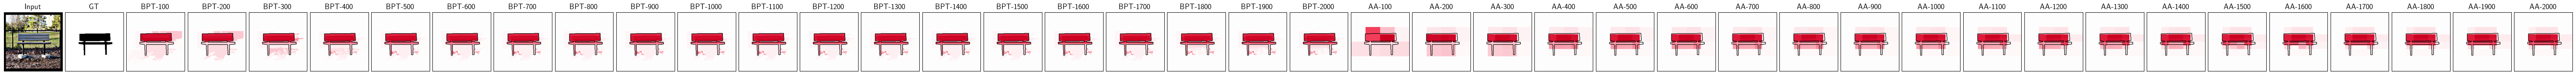

In [116]:
plot_colorbar = False
plot_title    = True
save_fig      = True
fontsize      = 14
print(results_path_single)
# get_headers()
get_exp_header()
print('-'*120)
print(f'{"method":<20}{"Explained Prob":<15}')
for ii, (n,c,_) in enumerate(methods):
    if n!='aIDG':
        continue
    print(f'{n:<20}{np.sum(heatmaps[n][0])}')
fun_plot_heatmaps(heatmaps,methods,path=results_path_single,destroy_fig=False, selected_ext='png', 
                  save_fig=save_fig,plot_colorbar=plot_colorbar,plot_title=plot_title)

## Visualize IoU and GT

|  MODEL_TYPE      | PRETRAINED_MODEL       | BACKGROUND_TYPE        | FILENAME               |
-----------------------------------------------------------------------------------------------
|  ideal           | resnet                 | gray                   | exp_E2                 |


IoU: 0it [00:00, ?it/s]

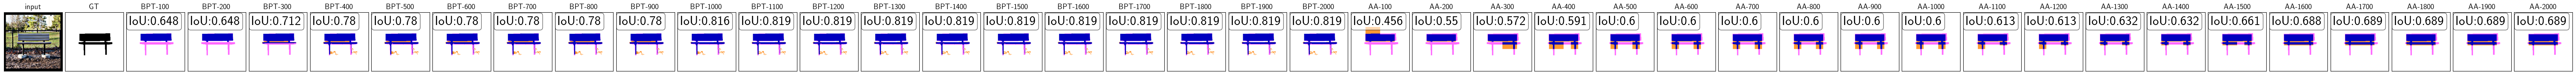

In [117]:
plot_title = True
save_fig   = True
get_exp_header()
fun_plot_IoU(heatmaps,IoU,methods,path=results_path_single,destroy_fig=False, selected_ext='png',plot_title=plot_title, save_fig=save_fig,fontsize=fontsize)

In [118]:
params.pretrained_model_type, params.model_type

('resnet', 'ideal')

## PLOT AUCs

|  MODEL_TYPE      | PRETRAINED_MODEL       | BACKGROUND_TYPE        | FILENAME               |
-----------------------------------------------------------------------------------------------
|  ideal           | resnet                 | gray                   | exp_E2                 |


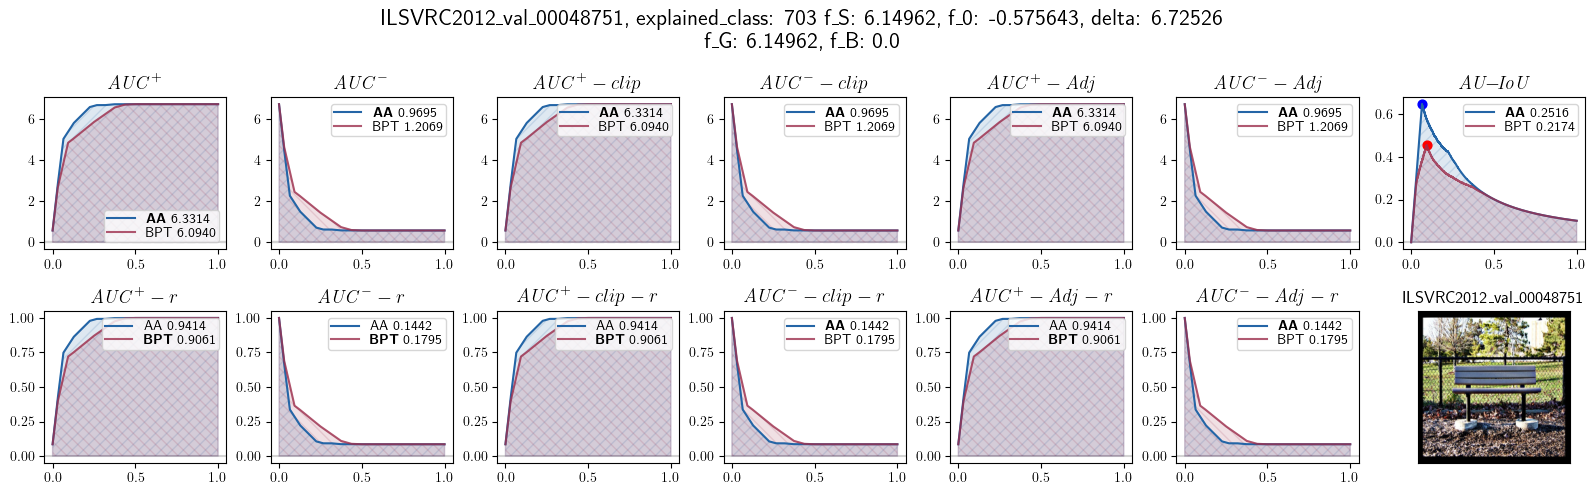

In [119]:
get_exp_header()

AA_name = 'Partition' if params.model_type!='ideal' else 'AA'
list_variants=['BPT-100', f'{AA_name}-100']


plt_ttl = f'{image_n}, explained_class: {predicted_cls} '\
                            f'f_S:\ {f_S:0.6}, f_0: {f_0:0.6}, delta: {abs(f_S-f_0):0.6}\n'\
                            f'f_G: {f_G:0.6}, f_B: {f_B:0.6}'

fun_plot_performance(aucI,aucD,IoU,list_variants=list_variants,path=results_path, file_name=image_n,layout='2rows',
                                     set_title=True,ttl=plt_ttl)
# fun_plot_performance(aucI,aucD,IoU,path=results_path_single)

## fun_plot_performance_comparison

In [147]:
from matplotlib import rc
rc('text',usetex=True)
rc('text.latex', preamble='\\usepackage{color}')

def fun_plot_performance_comparison(heatmaps, IoU,
                         list_variants=['BPT-100', 'AA-100', 'LIME-100'],
                        #  budget_set='100',
                         path=None,
                         file_name='',
                         save_fig=True,
                         fontsize=14,
                         set_title=False,
                         plot_lime=False,
                         ttl=None,
                         layout='row'  # 'row' or '2rows'
                         ):
    import numpy as np
    import matplotlib.pyplot as plt

    # Order of plots (grouped by column for 2-row layout)
    plot_defs = [
        # {'title': '$\\mathit{AUC}^{+}$',         'typee': 'auc',        'from': 'aucI'}, # 0
        # {'title': '$\\mathit{AUC}^{-}$',         'typee': 'auc',        'from': 'aucD'}, # 1
        # {'title': '$\\mathit{AUC}^{+}-clip$',     'typee': 'auc_clip',   'from': 'aucI'}, # 2
        # {'title': '$\\mathit{AUC}^{-}-clip$',     'typee': 'auc_clip',   'from': 'aucD'}, # 3
        # {'title': '$\\mathit{AUC^{+}-Adj}$',     'typee': 'auc_adj',    'from': 'aucI'}, # 4
        # {'title': '$\\mathit{AUC^{-}-Adj}$',     'typee': 'auc_adj',    'from': 'aucD'}, # 5
        
        {'title': '$\\mathit{AU}{\!-\!}\\mathit{IoU}$', 'typee': 'auc_iou', 'from': 'iou'}, # 6 
        #####################################################################

        # {'title': '$\\mathit{AUC}^{+}-r$',       'typee': 'auc_r',      'from': 'aucI'}, # 7
        # {'title': '$\\mathit{AUC}^{-}-r$',       'typee': 'auc_r',      'from': 'aucD'}, # 8
        # {'title': '$\\mathit{AUC}^{+}-clip-r$', 'typee': 'auc_clip_r', 'from': 'aucI'}, # 9
        # {'title': '$\\mathit{AUC}^{-}-clip-r$', 'typee': 'auc_clip_r', 'from': 'aucD'}, # 10
        # {'title': '$\\mathit{AUC^{+}-Adj-r}$',   'typee': 'auc_adj_r',  'from': 'aucI'}, # 11
        # {'title': '$\\mathit{AUC^{-}-Adj-r}$',   'typee': 'auc_adj_r',  'from': 'aucD'}, # 12 
        
    ]
    save_version = list_variants[0].split('-')[-1]
    # Reorder plot_defs for 2-row layout: interleaved columns
    if layout == '2rows':
        top = plot_defs[0::2]
        bottom = plot_defs[1::2]
        plot_defs = [None]*(len(top)+len(bottom))
        plot_defs[::2] = top
        plot_defs[1::2] = bottom

    total_variant = len(plot_defs)

    # Layout config
    if layout == 'row':
        nrows, ncols = 1, total_variant+2
        fig_width, fig_height = 5, 2.5

    elif layout == '2rows':
        nrows, ncols = 2, int(np.ceil(total_variant / 2))
        fig_width, fig_height = 16, 5
    else:
        raise ValueError("layout must be either 'row' or '2rows'")

    fig, axes = plt.subplots(nrows, ncols, figsize=(fig_width, fig_height))

    # print('row - cols', nrows, ncols)
    axes = axes.flatten()

    # Alias
    # aucI_aa = aucI[list_variants[0]]
    # aucD_aa = aucD[list_variants[0]]
    auc_IoU_aa = IoU[list_variants[0]]

    # aucI_bpt = aucI[list_variants[1]]
    # aucD_bpt = aucD[list_variants[1]]
    auc_IoU_bpt = IoU[list_variants[1]]
    if len(list_variants)==3:
        # aucI_lime = aucI[list_variants[2]]
        # aucD_lime = aucD[list_variants[2]]
        auc_IoU_lime = IoU[list_variants[2]]

    # def get_params_auc(auc_, typee):
    #     return {
    #         'auc':        (auc_['xs'], auc_['ys'],     auc_['ms'], auc_['auc']),
    #         'auc_r':      (auc_['xs'], auc_['ysr'],    auc_['ms'], auc_['auc_r']),
    #         'auc_adj':    (auc_['xs'], auc_['y_adj'],  auc_['ms'], auc_['auc_adj']),
    #         'auc_adj_r':  (auc_['xs'], auc_['y_adjr'], auc_['ms'], auc_['auc_adjr']),
    #         'auc_clip':   (auc_['xs'], auc_['y_clip'], auc_['ms'], auc_['auc_clip']),
    #         'auc_clip_r': (auc_['xs'], auc_['y_clipr'],auc_['ms'], auc_['auc_clipr']),
    #     }.get(typee, (None, None, None, None))

    def get_params_iou(iou_, typee):
        if typee == 'auc_iou':

            # xmb, ymb = iou_[3], np.max(iou_[1])
            Xa, Ya, Ma, La = iou_[0], iou_[1], None, iou_[4]
            xma, yma = iou_[3], np.max(iou_[1])
            return Xa, Ya, Ma, La, xma, yma
        return None, None, None, None, None, None


    ############## ADD IOU

    print('computing IOU for', n, list_variants[0], list_variants)
    img, max_IoU = vis_IoU(heatmaps[list_variants[0]][0], IoU[list_variants[0]][2], ground_truth), np.max(IoU[list_variants[0]][1])
    axes[1].imshow(img)
    axes[1].text(10, 30, f'IoU: {max_IoU:.3}', fontsize=fontsize, bbox=props, weight='bold')
    axes[1].set_xticks([])
    axes[1].set_yticks([])

    for i, config in enumerate(plot_defs):
        ax = axes[i+2]
        title = config['title']
        typee = config['typee']
        source = config['from']

        Xa, Ya, Ma, La, xma, yma = get_params_iou(auc_IoU_aa,  typee)
        Xb, Yb, Mb, Lb, xmb, ymb = get_params_iou(auc_IoU_bpt, typee)
        if len(list_variants)==3:
            Xl, Yl, Ml, Ll, xml, yml = get_params_iou(auc_IoU_lime,   typee)

        # Boldness logic
        Sa, Sb = ('\\textbf', '') if La < Lb else ('', '\\textbf')
        if i in [0,2,4,6,8]: Sa, Sb = Sb, Sa

        # Plot
        ax.plot(Xa, Ya, c='#2465a6', label=f'{Sa}{{AA}} {La:.4f}')
        ax.fill_between(Xa, Ya, color='#2465a6', alpha=0.15, hatch='///')
        ##########
        ax.plot(Xb, Yb, c='#9d2f4d', label=f'{Sb}{{BPT}} {Lb:.4f}', alpha=0.80)
        ax.fill_between(Xb, Yb, color='#9d2f4d', alpha=0.15, hatch='\\\\\\')
        ##########
        if len(list_variants)==3:
            if plot_lime:
                ax.plot(Xl, Yl, c="#01B0A7", label=f'{Sb}{{LM}} {Ll:.4f}', alpha=0.80)
                ax.fill_between(Xl, Yl, color='#01B0A7', alpha=0.15, hatch='\\\\\\')


        if typee == 'auc_iou':
            ax.scatter(xma, yma, s=40, color='blue')
            ax.scatter(xmb, ymb, s=40, color='red')

        if i < 4:
            ax.axhline(0.0, ls='--', c='grey', zorder=0)  # placeholder for f_S - f_0

        ax.axhline(0, c='lightgrey', zorder=0)
        ax.legend(borderpad=0.2, labelspacing=0.1, loc='upper right' if i>=1 else 'lower right')
        ax.set_title(title, fontsize=fontsize)
    
    axes[0].imshow(image_to_explain)
    axes[0].set_xticks([])
    axes[0].set_yticks([])
    axes[0].set_title(ttl.split(",")[0].split('_')[-1])
    if set_title:
        plt.suptitle(f'{ttl}', fontsize=16)
    plt.tight_layout()

    if save_fig and path is not None:
        plt.savefig(f'{path}/{file_name}_{save_version}_paired_auc_metrics.png', dpi=150, bbox_inches='tight', pad_inches=0.02)
    plt.show()


AA
BPT
----------------------------------------------------------------------------------------------------
|  MODEL_TYPE      | PRETRAINED_MODEL       | BACKGROUND_TYPE        | FILENAME               |
-----------------------------------------------------------------------------------------------
|  ideal           | resnet                 | gray                   | exp_E2                 |
computing IOU for AA-2000 BPT-100 ['BPT-100', 'AA-100']


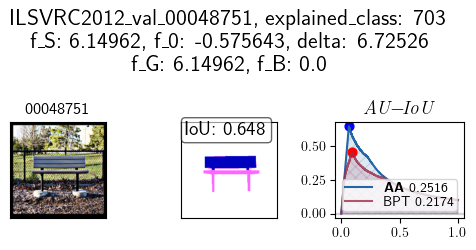

computing IOU for AA-2000 BPT-1000 ['BPT-1000', 'AA-1000']


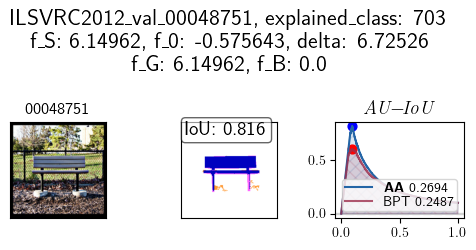

computing IOU for AA-2000 BPT-1100 ['BPT-1100', 'AA-1100']


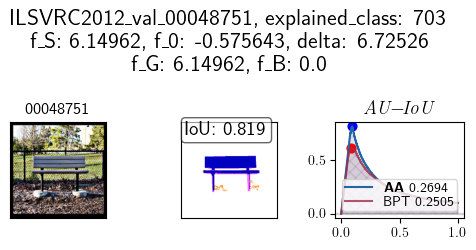

computing IOU for AA-2000 BPT-1200 ['BPT-1200', 'AA-1200']


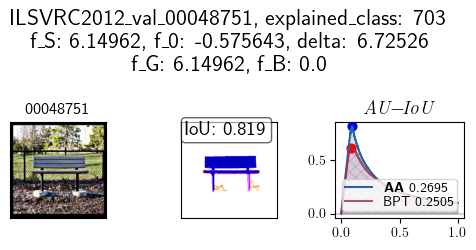

computing IOU for AA-2000 BPT-1300 ['BPT-1300', 'AA-1300']


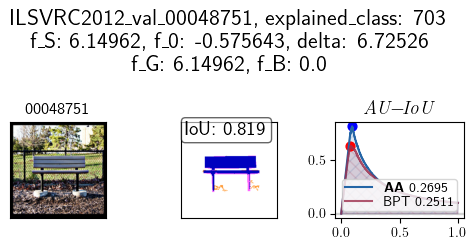

computing IOU for AA-2000 BPT-1400 ['BPT-1400', 'AA-1400']


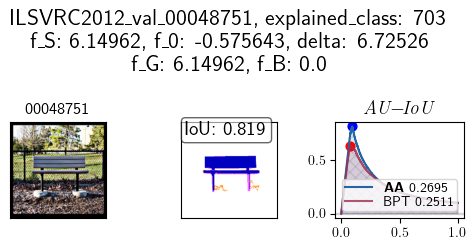

computing IOU for AA-2000 BPT-1500 ['BPT-1500', 'AA-1500']


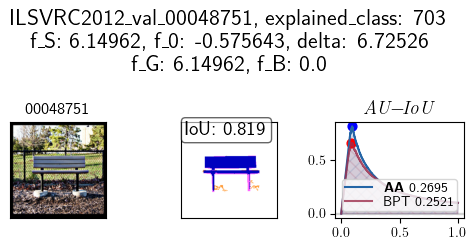

computing IOU for AA-2000 BPT-1600 ['BPT-1600', 'AA-1600']


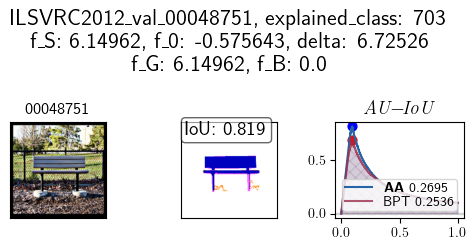

computing IOU for AA-2000 BPT-1700 ['BPT-1700', 'AA-1700']


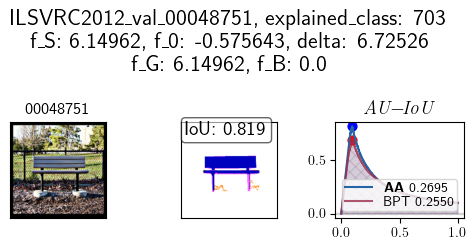

computing IOU for AA-2000 BPT-1800 ['BPT-1800', 'AA-1800']


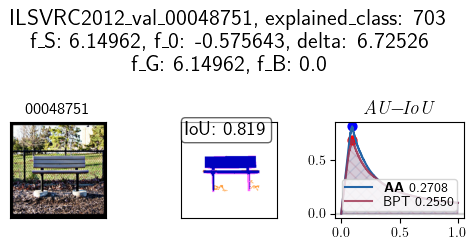

computing IOU for AA-2000 BPT-1900 ['BPT-1900', 'AA-1900']


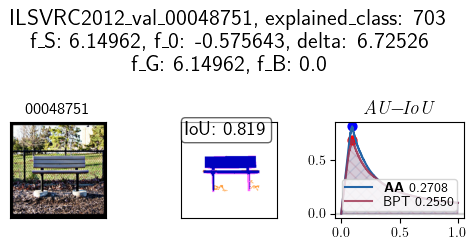

computing IOU for AA-2000 BPT-200 ['BPT-200', 'AA-200']


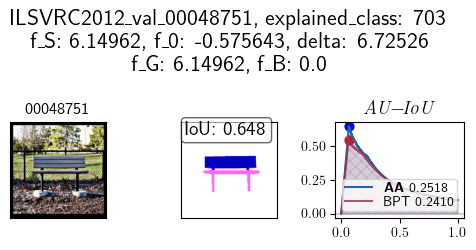

computing IOU for AA-2000 BPT-2000 ['BPT-2000', 'AA-2000']


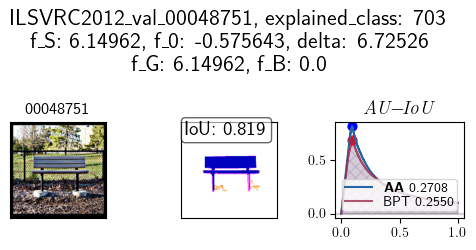

computing IOU for AA-2000 BPT-300 ['BPT-300', 'AA-300']


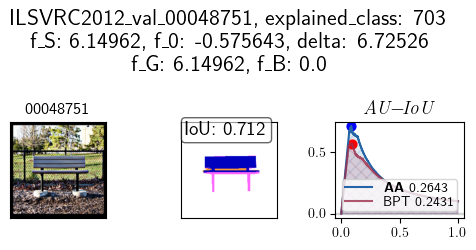

computing IOU for AA-2000 BPT-400 ['BPT-400', 'AA-400']


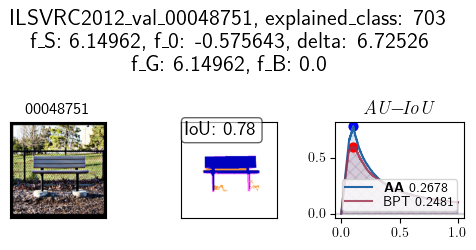

computing IOU for AA-2000 BPT-500 ['BPT-500', 'AA-500']


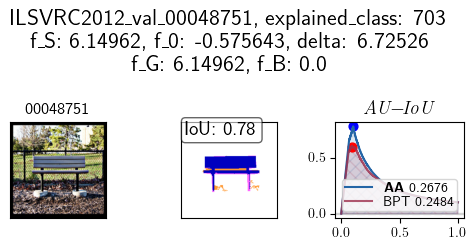

computing IOU for AA-2000 BPT-600 ['BPT-600', 'AA-600']


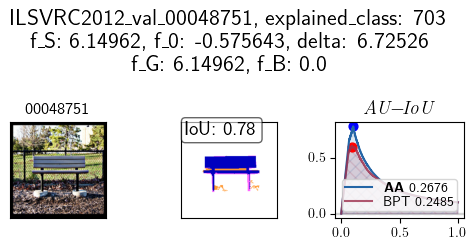

computing IOU for AA-2000 BPT-700 ['BPT-700', 'AA-700']


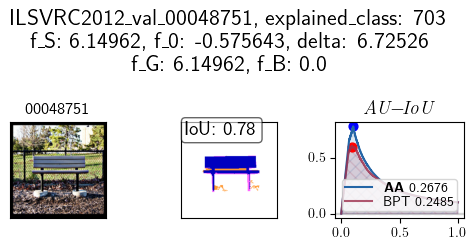

computing IOU for AA-2000 BPT-800 ['BPT-800', 'AA-800']


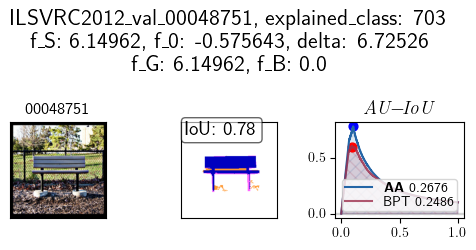

computing IOU for AA-2000 BPT-900 ['BPT-900', 'AA-900']


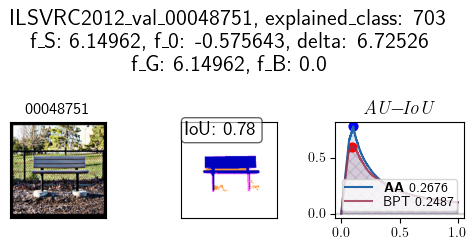

In [148]:
budgets = np.unique([key.split('-')[-1] for key in aucI.keys()])
xai_methods = np.unique([key.split('-')[0] for key in aucI.keys()])

for xaim in xai_methods:
    print(xaim)
print('-'*100)
# for b in budgets:
    # print(b)

get_exp_header()
AA_name = 'Partition' if params.model_type!='ideal' else 'AA'

plt_ttl = f'{image_n}, explained_class: {predicted_cls} \n'\
                            f'f_S:\ {f_S:0.6}, f_0: {f_0:0.6}, delta: {abs(f_S-f_0):0.6}\n'\
                            f'f_G: {f_G:0.6}, f_B: {f_B:0.6}'

for b in budgets:
    # print(b)
    list_variants=[f'BPT-{b}', f'{AA_name}-{b}']
    fun_plot_performance_comparison(heatmaps,IoU,list_variants=list_variants,
                        path=results_path, file_name=image_n,layout='row',
                        set_title=True,ttl=plt_ttl)
    
    # fun_plot_IoU_filtered(methods,IoU, heatmaps,filter_methods=filter_methods,path=results_path_selected_convergence,
    #                           destroy_fig=False,save_fig=save_fig,plot_title=plot_title, dpi=100, fontsize = 20)

    # break

In [81]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
rc('text', usetex=True)
rc('text.latex', preamble='\\usepackage{color}')

def plot_iou_row_from_aucI_only(
    aucI,
    image_to_explain,
    figsize_per_col=3.0,
    fontsize=12,
    save_path=None,
    file_name='iou_row',
    colors=None
):
    # ---------- helper: first non-None among named keys, without boolean ops ----------
    def first_present(d, keys):
        for k in keys:
            if k in d and d[k] is not None:
                return d[k]
        return None

    # ---------- IoU extractor (fixed) ----------
    def extract_iou(entry):
        # Case 1: tuple/list like (X, Y, _, xbest, auc)
        if isinstance(entry, (list, tuple)) and len(entry) >= 2:
            X = np.asarray(entry[0])
            Y = np.asarray(entry[1])
            xbest = float(entry[3]) if len(entry) > 3 else float(X[int(np.argmax(Y))])
            aucv  = float(entry[4]) if len(entry) > 4 else float(np.trapz(Y, X))
            return X, Y, xbest, aucv

        # Case 2: dict with possible field name variants
        if isinstance(entry, dict):
            X = first_present(entry, ['iou_X', 'X', 'xs', 'Xa'])
            Y = first_present(entry, ['iou_Y', 'Y', 'ys', 'Ya'])
            if X is None or Y is None:
                raise ValueError(
                    "Couldn't find IoU X/Y in aucI entry. "
                    "Expected keys like iou_X/iou_Y or X/Y or xs/ys."
                )
            X = np.asarray(X); Y = np.asarray(Y)
            xbest = entry.get('xbest')
            if xbest is None:
                xbest = float(X[int(np.argmax(Y))])
            else:
                xbest = float(xbest)
            aucv = entry.get('auc')
            if aucv is None:
                aucv = float(np.trapz(Y, X))
            else:
                aucv = float(aucv)
            return X, Y, xbest, aucv

        raise TypeError("Unsupported aucI entry format for IoU extraction.")

    # ---------- infer methods/budgets ----------
    keys = list(aucI.keys())
    if not keys:
        raise ValueError("aucI is empty.")

    def _method_of(k): return k.split('-')[0].upper()
    def _budget_of(k): return k.split('-')[-1]

    methods_all  = np.unique([_method_of(k) for k in keys])
    budgets_all  = np.unique([_budget_of(k) for k in keys])

    # Require AA and BPT
    if not {'AA','BPT'}.issubset(set(methods_all)):
        raise ValueError("Both 'AA' and 'BPT' must exist in aucI keys.")

    # budgets present for BOTH AA and BPT
    def _num_or_str(b):
        try: return (0, float(b))
        except: return (1, b)
    shared_budgets = sorted(
        [b for b in budgets_all if f'AA-{b}' in aucI and f'BPT-{b}' in aucI],
        key=_num_or_str
    )
    if not shared_budgets:
        raise ValueError("No shared budgets between AA and BPT in aucI.")

    # ---------- colors ----------
    if colors is None:
        colors = {'AA': '#2465a6', 'BPT': '#9d2f4d'}
    colors.setdefault('AA', 'gray')
    colors.setdefault('BPT', 'gray')

    # ---------- figure ----------
    ncols = 1 + len(shared_budgets)
    fig_w = max(6.0, figsize_per_col * ncols)
    fig_h = 2.8
    fig, axes = plt.subplots(1, ncols, figsize=(fig_w, fig_h))
    if ncols == 1:
        axes = [axes]

    # col 0: input
    axes[0].imshow(image_to_explain)
    axes[0].set_xticks([]); axes[0].set_yticks([])
    axes[0].set_title("Input", fontsize=fontsize)

    # each budget column: AA vs BPT
    for c, b in enumerate(shared_budgets, start=1):
        ax = axes[c]
        legends = []
        for m in ['AA','BPT']:
            key = f'{m}-{b}'
            X, Y, xbest, aucv = extract_iou(aucI[key])
            ax.plot(X, Y, lw=2, alpha=0.9, c=colors[m], label=f'{m} {aucv:.4f}')
            ax.fill_between(X, Y, alpha=0.15, color=colors[m])
            ybest = float(np.max(Y))
            ax.scatter([xbest], [ybest], s=28)
            legends.append((m, aucv))

        # bold best in legend
        best_m = max(legends, key=lambda t: t[1])[0]
        handles, labels = ax.get_legend_handles_labels()
        new_labels = [f'\\textbf{{{lab}}}' if lab.split()[0]==best_m else lab for lab in labels]
        ax.legend(handles, new_labels, loc='lower right', frameon=False, fontsize=fontsize-2)

        ax.set_title(r'$\mathit{AU}{-}\mathit{IoU}$' + f' ({b})', fontsize=fontsize)
        ax.set_xlabel('Budget steps', fontsize=fontsize-2)
        ax.set_ylabel('IoU', fontsize=fontsize-2)
        ax.grid(alpha=0.2)

    plt.tight_layout(pad=0.6)
    if save_path is not None:
        out = f'{save_path}/{file_name}.png'
        plt.savefig(out, dpi=150, bbox_inches='tight', pad_inches=0.02)
    plt.show()

    return {
        'methods_found': [str(m) for m in methods_all],
        'shared_budgets': [str(b) for b in shared_budgets]
    }


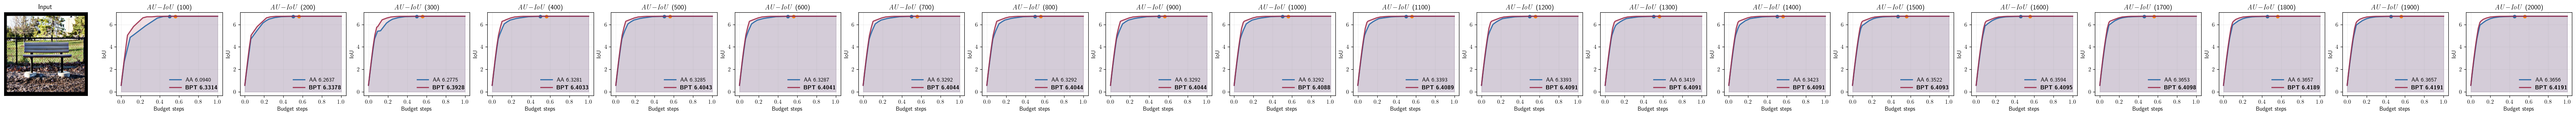

{'methods_found': ['AA', 'BPT'], 'shared_budgets': ['100', '200', '300', '400', '500', '600', '700', '800', '900', '1000', '1100', '1200', '1300', '1400', '1500', '1600', '1700', '1800', '1900', '2000']}


In [82]:
# aucI must contain keys like 'AA-100','BPT-100','AA-500','BPT-500', ...
# Each aucI[key] should carry enough info for extract_iou() to get X,Y,(xbest),(auc).

info = plot_iou_row_from_aucI_only(
    aucI=aucI,
    image_to_explain=image_to_explain,
    save_path=None,           # or "figs"
    file_name='iou_row'
)
print(info)  # shows methods found and shared budgets


# FUNCT: create log file

In [83]:
def create_log_file(plots_path__,start_time, verbose=False):
    # Define log messages
    log_messages = ""
    log_save_data_msg = f"saving data :\t{plots_path__}\n"
    log_code_started_msg = f"code started:\t{start_time}\n"
    log_table_header_msg = f"{'Image_no': <25} {'predicted_class': <22} {'predicted_prob': <20} {'class_id': <15} {'background_class': <15}\n"
    log_header_main = f"| {'FILENAME':22} | {'MODEL_TYPE':15} | {'PRETRAINED_MODEL':22} | {'BACKGROUND_TYPE':22} | {'Total':22} |\n"
    log_header_main_data = f"| {params.file_name:22} | {params.model_type:15} | {params.pretrained_model_type:22} | {params.background_type:22} | {str(len(files)):22} |\n"
    log_separator_dash = "-" * 120 + "\n"
    log_separator_bold = "=" * 120 + "\n"
    
    # Append log messages
    log_messages += log_separator_bold
    log_messages += log_header_main
    log_messages += log_header_main_data
    log_messages += log_separator_dash
    log_messages += log_save_data_msg
    log_messages += log_code_started_msg
    log_messages += log_separator_dash
    log_messages += log_table_header_msg

    # Print separator lines and log messages
    if verbose:
        print(log_separator_bold.strip())
        print(log_header_main.strip())
        print(log_header_main_data.strip())
    
        print(log_separator_bold.strip())
        print(log_save_data_msg.strip())
        print(log_code_started_msg.strip())
        
        print(log_table_header_msg.strip())
        print(log_separator_dash.strip())
    return log_messages

# log_messages = create_log_file(results_path_selected,start_time)
# print(log_messages)


# RUN TEST ON SELECTED IMAGES for Figures
Run below two cells to produce data for **Figure 4**, **Figure 6**,  **Figure 8**,**Figure 10**, and **Figure 12**

In [86]:

if params.file_name=='exp_E1':
    figure_no = 4     # exp 
elif params.file_name=='exp_E2':
    figure_no = 8     # exp e2
elif params.file_name=='exp_E1_ViT':
    figure_no = 8     # exp e2
elif params.file_name=='exp_E3':
    figure_no = 8     # exp e3
elif params.file_name=='exp_E4':
    figure_no = 10    # exp e4
elif params.file_name=='exp_E5':
    figure_no = 8 #12      # exp e5
else:
    figure_no = 8
######################################################################

# figure_no = 4     # exp 
# figure_no = 6     # exp 
# figure_no = 8     # exp e2
# figure_no = 10    # exp e4
# figure_no = 12      # exp e5
# figure_no = 13 # Multi Objects
######################################################################
select_set = 'selected' # selected , full 
######################################################################
if select_set=='selected':
    log_file_selected = f'{results_path_selected}/log_file.txt'
    # plotsIoU_path = plots_path = results_path_selected
    # results_path   = results_path_selected
    selected_ext  = 'svg'
    if figure_no is None:
        file_selected = [17505]
    elif figure_no==4:
        file_selected = [618, 17635, 5428, 8733]

    elif figure_no==6:
        file_selected = [17505,3843,4203,25140,7684,8292,11346,20075]    # Figure 6 Experiment E1 Extended
        #file_selected = [3843]
    elif figure_no==8:
        file_selected = [17505,3843,4203,25140,7684,8292,11346,20075,618,17635,5428,8733,1739,3223]                 # Figure 8, Experiment E2
    elif figure_no==13:
        file_selected = [28713,37846]
    else:
        file_selected = [47683,17635,5428,8733]                          
    file_selected_ls = []    
    for fs in file_selected:
        fs_st = f"ILSVRC2012_val_{fs:08}"
        file_selected_ls.append(fs_st)

print('file_name:\t',      params.file_name)
print('select_set:\t',      select_set)
print('figure_no:\t',        figure_no)
print('file_selected:\t',file_selected)

file_name:	 exp_E2
select_set:	 selected
figure_no:	 8
file_selected:	 [17505, 3843, 4203, 25140, 7684, 8292, 11346, 20075, 618, 17635, 5428, 8733, 1739, 3223]


In [88]:
file_selected = file_selected[0:3]
file_selected

[17505, 3843, 4203]

In [149]:
[n for n,_,_ in methods]

['BPT-100',
 'BPT-200',
 'BPT-300',
 'BPT-400',
 'BPT-500',
 'BPT-600',
 'BPT-700',
 'BPT-800',
 'BPT-900',
 'BPT-1000',
 'BPT-1100',
 'BPT-1200',
 'BPT-1300',
 'BPT-1400',
 'BPT-1500',
 'BPT-1600',
 'BPT-1700',
 'BPT-1800',
 'BPT-1900',
 'BPT-2000',
 'AA-100',
 'AA-200',
 'AA-300',
 'AA-400',
 'AA-500',
 'AA-600',
 'AA-700',
 'AA-800',
 'AA-900',
 'AA-1000',
 'AA-1100',
 'AA-1200',
 'AA-1300',
 'AA-1400',
 'AA-1500',
 'AA-1600',
 'AA-1700',
 'AA-1800',
 'AA-1900',
 'AA-2000']

## RUN FOR PROBABILITY OF SINGLE EXMAPLE 

In [150]:
def np_softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()

In [151]:

# file_selected_ls = []
# file_selected = [25140]
# # file_selected = [47683]

# for fs in file_selected:
#     fs_st = f"ILSVRC2012_val_{fs:08}"
#     file_selected_ls.append(fs_st)

# files_selected

In [152]:
files_selected = []

for image_name in files:
    image_n = image_name.split('.')[0].split('//')[-1]
    if select_set=='selected' and image_n not in file_selected_ls:
        continue
    files_selected.append(image_name)
files_selected

['D:\\DS\\ImageNet\\ImageNetS/ILSVRC2012_img_val_S/ImageNetS50/validation-segmentation//n01443537//ILSVRC2012_val_00004677.png',
 'D:\\DS\\ImageNet\\ImageNetS/ILSVRC2012_img_val_S/ImageNetS50/validation-segmentation//n01443537//ILSVRC2012_val_00006007.png',
 'D:\\DS\\ImageNet\\ImageNetS/ILSVRC2012_img_val_S/ImageNetS50/validation-segmentation//n01443537//ILSVRC2012_val_00013623.png',
 'D:\\DS\\ImageNet\\ImageNetS/ILSVRC2012_img_val_S/ImageNetS50/validation-segmentation//n01443537//ILSVRC2012_val_00018075.png',
 'D:\\DS\\ImageNet\\ImageNetS/ILSVRC2012_img_val_S/ImageNetS50/validation-segmentation//n01443537//ILSVRC2012_val_00020436.png',
 'D:\\DS\\ImageNet\\ImageNetS/ILSVRC2012_img_val_S/ImageNetS50/validation-segmentation//n01443537//ILSVRC2012_val_00020785.png',
 'D:\\DS\\ImageNet\\ImageNetS/ILSVRC2012_img_val_S/ImageNetS50/validation-segmentation//n01443537//ILSVRC2012_val_00021905.png',
 'D:\\DS\\ImageNet\\ImageNetS/ILSVRC2012_img_val_S/ImageNetS50/validation-segmentation//n01443537

In [94]:
for image_name in tqdm(files_selected):

    data_time,data = {} , {}
    image_n = image_name.split('.')[0].split('//')[-1]
    if select_set=='selected' and image_n not in file_selected_ls:
        continue
    #print(image_n, file_selected_ls)
    st_load = time.time()
    load_image_to_explain(f'{image_name}', bg_type=params.background_type)
    single_img_name = image_name
    imagenetS_classes = set(np.unique(ground_truth))
    imagenetS_classes.discard(0)
    imagenetS_classes.discard(1000)
    if len(imagenetS_classes)>1:
        print('classes more than 1')
        continue
    assert len(imagenetS_classes)==1
    class_mask_id = list(imagenetS_classes)[0]
    imagenet_class_id = imagenetS_to_imagenet[class_mask_id]
    # table_header_msg = f"{'Image no': <{25}} {'predicted class': <{22}} {'predicted prob': <{20}} {'predicted class-id': <{15}} {'background class': <{15}}\n"
    table_msg = f"{image_n.split('_')[2]: <{25}} {class_names[predicted_cls]: <{22}} {f_S: <{20.6}} | {np_softmax(predicted_fS)[predicted_cls]: <{20.6}} | {predicted_cls: <{15}} {f_0: <{15}}\n"
    # log_messages += table_msg
    print(table_msg.strip())

  0%|          | 0/14 [00:00<?, ?it/s]

00001739                  tree_frog              7.06206              | 0.527651             | 31              -0.24676398932933807
00017505                  tree_frog              6.29837              | 0.346873             | 31              -0.24676398932933807
00025140                  red_fox                6.31935              | 0.303999             | 277             -0.5474911332130432
00017635                  ladybug                6.24719              | 0.32021              | 301             -0.06957802921533585
00000618                  sulphur_butterfly      6.51228              | 0.400676             | 325             -0.8941940665245056
00003223                  wild_boar              7.51751              | 0.590999             | 342             -0.5882916450500488
00008292                  airliner               7.2926               | 0.563941             | 404             1.5034019947052002
00004203                  bullet_train           6.37368              | 0.316239 

In [ ]:
results_path_selected_convergence = os.path.join(results_path_selected, 'convergence')
os.makedirs(results_path_selected_convergence, exist_ok=True)

| FILENAME               | MODEL_TYPE      | PRETRAINED_MODEL       | BACKGROUND_TYPE        | Total                  |
| exp_E2                 | ideal           | resnet                 | gray                   | 752                    |
------------------------------------------------------------------------------------------------------------------------
saving data :	e:\Cloud\RashidPHD\Supplimentary_Files\AAAI_26\notebooks\E1_E2_E3_E7\results\resnet\resnet_ideal_gray\selected
code started:	2025-11-10 21:19:00.674600
------------------------------------------------------------------------------------------------------------------------
Image_no                  predicted_class        predicted_prob       class_id        background_class



  0%|          | 0/14 [00:00<?, ?it/s]

00001739                  tree_frog              7.06206              31              -0.24676398932933807


Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

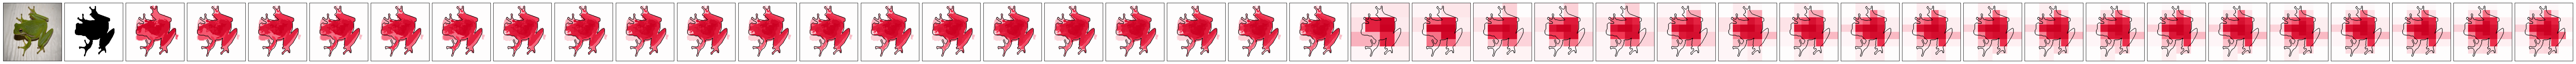

score:   0%|          | 0/40 [00:00<?, ?it/s]

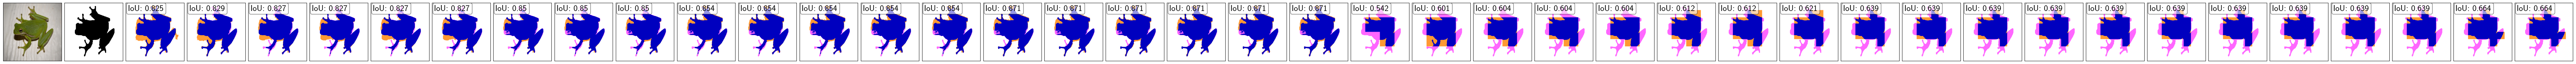

------------------------------------------------------------------------------------------------------------------------
00017505                  tree_frog              6.29837              31              -0.24676398932933807


Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

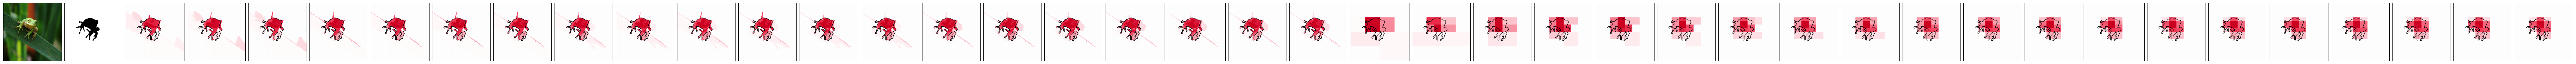

score:   0%|          | 0/40 [00:00<?, ?it/s]

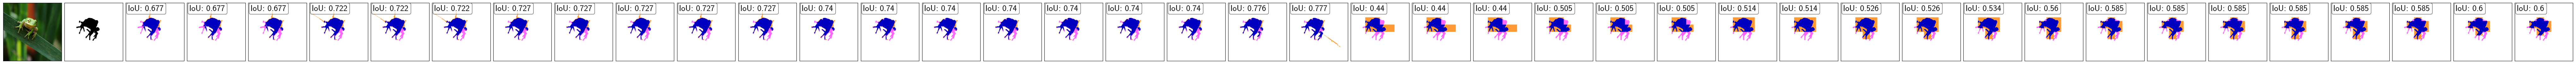

------------------------------------------------------------------------------------------------------------------------
00025140                  red_fox                6.31935              277             -0.5474911332130432


Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

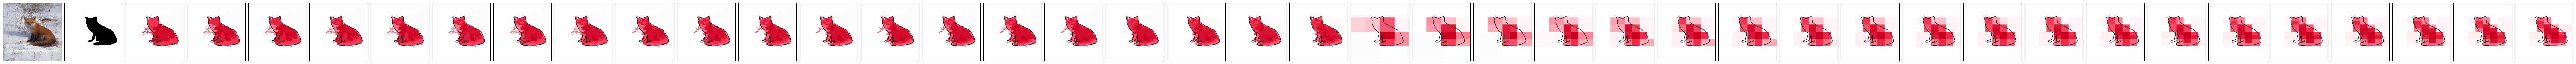

score:   0%|          | 0/40 [00:00<?, ?it/s]

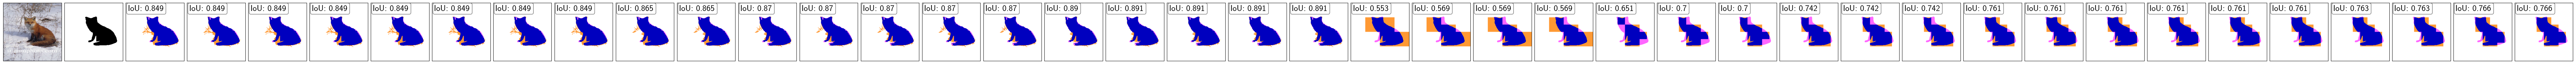

------------------------------------------------------------------------------------------------------------------------
00017635                  ladybug                6.24719              301             -0.06957802921533585


Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

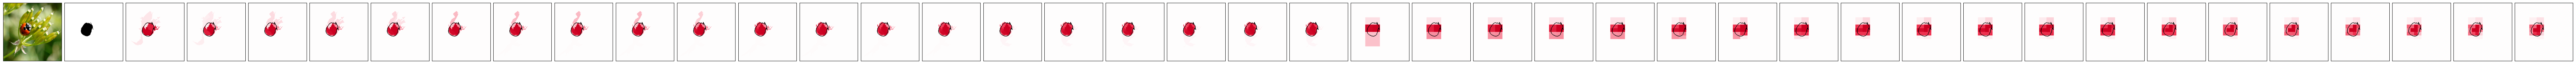

score:   0%|          | 0/40 [00:00<?, ?it/s]

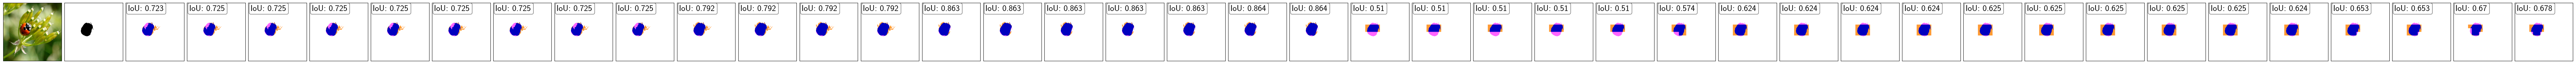

------------------------------------------------------------------------------------------------------------------------
00000618                  sulphur_butterfly      6.51228              325             -0.8941940665245056


Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [97]:
data_to_csv =  []

plot_heatmaps            = True
plot_IoU                 = True
save_fig                 = True
destroy_fig              = False
save_vectors_heatmaps    = True
save_vectors_evaluation  = False
plot_title               = False
st_full                  = time.time()

# disallowed_vectors = ['LRP','GradCAM','aIDG','aGradExpl','ShapGradE']
# if model_type=='real':

# filter_methods = ['AA-500','Partition-500','BPT-500','LIME-500']

filter_methods = [n for n,_,_ in methods]

# disallowed_vectors = []
methods_ls,methods_ls_id = [],[]
for i_id,(i,_,_) in enumerate(methods):
    i = i.replace('Partition','PE')
    i = i.replace('GradCAM','GC')
    i = i.replace('-','_')
    methods_ls.append(i)
    methods_ls_id.append(i_id+1)
files_success =[]
start_time = datetime.now()

log_messages = create_log_file(results_path_selected,start_time)
print(log_messages)

for image_name in tqdm(files_selected):

    data_time,data = {} , {}
    image_n = image_name.split('.')[0].split('//')[-1]
    if select_set=='selected' and image_n not in file_selected_ls:
        continue
    #print(image_n, file_selected_ls)
    st_load = time.time()
    load_image_to_explain(f'{image_name}', bg_type=params.background_type)
    single_img_name = image_name
    imagenetS_classes = set(np.unique(ground_truth))
    imagenetS_classes.discard(0)
    imagenetS_classes.discard(1000)
    if len(imagenetS_classes)>1:
        print('classes more than 1')
        continue
    assert len(imagenetS_classes)==1
    class_mask_id = list(imagenetS_classes)[0]
    imagenet_class_id = imagenetS_to_imagenet[class_mask_id]
    # table_header_msg = f"{'Image no': <{25}} {'predicted class': <{22}} {'predicted prob': <{20}} {'predicted class-id': <{15}} {'background class': <{15}}\n"
    table_msg = f"{image_n.split('_')[2]: <{25}} {class_names[predicted_cls]: <{22}} {f_S: <{20.6}} {predicted_cls: <{15}} {f_0: <{15}}\n"
    log_messages += table_msg
    print(table_msg.strip())
    if  imagenet_class_id!=predicted_cls:
        print(image_n, 'other class')
        continue

    class_tag = classid_to_tag[predicted_cls]
    ground_truth = ground_truth == class_mask_id
    time_load = time.time()-st_load
    ############     HeatMaps    ############
    heatmaps = {}
    files_success.append(image_n)
    time_exp = {}
    for n,_,funct in tqdm(methods, desc='Explanation',leave=False):
        if n not in filter_methods:
            continue
        
        heatmap_filename = f'{vector_path}//heatmaps_{image_n}_{n}.pkl'
        
        if save_vectors_heatmaps:
            if os.path.exists(heatmap_filename):
                # print(f'loaded : {image_n}_{n}.pkl')
                st = time.time()
                if n in filter_methods:
                    with open(heatmap_filename, 'rb') as rf:
                        heatmaps[n] = pickle.load(rf)
                time_exp[n] = time.time()-st
            else:
                st = time.time()
                heatmaps[n] = funct()
                time_exp[n] = time.time()-st
                if n in filter_methods:
                    # print(n, 'is allowed')
                    with open(heatmap_filename, 'wb') as pf:
                        pickle.dump(heatmaps[n], pf)
                else:
                    pass
                    # print(n, 'loaded from saved explanation')
        else:
            st = time.time()
            heatmaps[n] = funct()
            time_exp[n] = time.time()-st
            
    if plot_heatmaps:
        # fun_plot_heatmaps(heatmaps,methods,path=results_path_selected,destroy_fig=destroy_fig,save_fig=save_fig,plot_title=plot_title, dpi=100)
        # fun_plot_heatmaps_partial(methods,heatmaps,filter_methods=filter_methods,path=results_path_selected,destroy_fig=True,save_fig=save_fig,plot_title=plot_title, dpi=100)
        fun_plot_heatmaps_filtered(methods,heatmaps,filter_methods=filter_methods,path=results_path_selected_convergence,
                                   destroy_fig=False,save_fig=save_fig,plot_title=plot_title, dpi=100)
        
    ############     AUCs    ############
    aucD, aucI,IoU = {}, {},{}
    overlaps={}
    for n,_,_ in tqdm(methods, desc='score',leave=False):
        if n not in filter_methods:
            continue
        aucD_filename    = f'{vector_path}//aucD_{image_n}_{n}.pkl'
        aucI_filename    = f'{vector_path}//aucI_{image_n}_{n}.pkl'
        aucIoU_filename    = f'{vector_path}//aucIoU_{image_n}_{n}.pkl'
        #############     aucD    ############################
        st = time.time()
        # aucD[n] = saliency_to_auc(heatmaps[n][0], method='del')
        aucD[n] = saliency_to_auc(f_masked,heatmaps[n][0],f_S, f_0, predicted_cls, method='del', batch_size=batch_size)
               
        time_aucD = time.time()-st
        ############    aucI     ############################
        st = time.time()
        # aucI[n] = saliency_to_auc(heatmaps[n][0], method='ins')
        aucI[n] = saliency_to_auc(f_masked,heatmaps[n][0],f_S, f_0, predicted_cls, method='ins', batch_size=batch_size)
        time_aucI = time.time()-st
        st = time.time()
        ###########   IOU  ############################
        IoU[n] = calc_IoU_curve(ground_truth.flatten(), heatmaps[n][0].flatten())

        time_auc_IoU = time.time()-st      
        ###############
        if save_vectors_evaluation:
            with open(aucD_filename, 'wb') as pf:
                pickle.dump(aucD, pf)
            with open(aucI_filename, 'wb') as pf:
                pickle.dump(aucI, pf)
            with open(aucIoU_filename, 'wb') as pf:
                pickle.dump(IoU, pf)
        
        data = {'image'         : image_n,
                'bg_type'       : params.background_type,
                'pred_cls'      : predicted_cls,
                'pred_lbl'      : class_names[predicted_cls],
                'f_S'           : f_S,
                'f_0'           : f_0,
                'f_T'           : np.sum(heatmaps[n][0]),
                'method'        : n,
                'threshold'     : IoU[n][2],
                'best_point'    : IoU[n][3],
                'max_IoU'       : np.max(IoU[n][1]),
                'au_IoU'        : IoU[n][4],
                ##############################
                'aucI_pred'     : aucI[n]['auc'],  # aucI[n][-3],
                'aucD_pred'     : aucD[n]['auc'],  # aucD[n][-3],
                ##############################
                'aucI_r'     : aucI[n]['auc_r'],  # aucI[n][-3],
                'aucD_r'     : aucD[n]['auc_r'],  # aucD[n][-3],
                ###
                'aucI_adj'     : aucI[n]['auc_adj'],  # aucI[n][-3],
                'aucD_adj'     : aucD[n]['auc_adj'],  # aucD[n][-3],
                ###
                'aucI_adj_r'     : aucI[n]['auc_adjr'],  # aucI[n][-3],
                'aucD_adj_r'     : aucD[n]['auc_adjr'],  # aucD[n][-3],
                ###
                ###############################
                # 'aucI_mse'      : aucI[n]['auc_mse'],  # aucI[n][-1],
                # 'aucD_mse'      : aucD[n]['auc_mse'],  # aucD[n][-1],
                'time_load'     : time_load,
                'time_exp'      : time_exp[n],
                'time_aucI'     : time_aucI,
                'time_aucD'     : time_aucD,
                'time_auc_IoU'  : time_auc_IoU,
                'time_total'    : time_load+time_exp[n]+time_aucI+time_aucD+time_auc_IoU
                }
        data_to_csv.append(data)
    if plot_IoU:
        # fun_plot_IoU(heatmaps,IoU,methods,path=results_path_selected,destroy_fig=destroy_fig,save_fig=save_fig,plot_title=plot_title, dpi=100)
        fun_plot_IoU_filtered(methods,IoU, heatmaps,filter_methods=filter_methods,path=results_path_selected_convergence,
                              destroy_fig=False,save_fig=save_fig,plot_title=plot_title, dpi=100, fontsize = 20)
    print('-'*120)
    df_selected = pd.DataFrame(data_to_csv)

time_full = time.time()-st_full
# print(f'Time for {select_set} test is :, {time_full}')

end_time = datetime.now()
# print('Duration: {}'.format(end_time - start_time))

chime.success()

time_full_msg = f"Time for {select_set} test is : {time_full}\n"
duration_msg = f"Duration: {format(end_time - start_time)}\n"
print(duration_msg)
print(time_full_msg)

log_messages += str("="*120 + '\n')
log_messages+= str(f'code completed {datetime.now()}\n')
log_messages += duration_msg
log_messages += time_full_msg

with open(log_file_selected, "w") as log_file:
    log_file.write(log_messages)

In [98]:
df_selected.head(5)

image bg_type  pred_cls   pred_lbl       f_S       f_0  \
0  ILSVRC2012_val_00001739    gray        31  tree_frog  7.062059 -0.246764   
1  ILSVRC2012_val_00001739    gray        31  tree_frog  7.062059 -0.246764   
2  ILSVRC2012_val_00001739    gray        31  tree_frog  7.062059 -0.246764   
3  ILSVRC2012_val_00001739    gray        31  tree_frog  7.062059 -0.246764   
4  ILSVRC2012_val_00001739    gray        31  tree_frog  7.062059 -0.246764   

        f_T   method  threshold  best_point   max_IoU    au_IoU  aucI_pred  \
0  7.062059  BPT-100   0.000151    0.332828  0.824556  0.473178   6.389586   
1  7.062059  BPT-200   0.000151    0.304369  0.828609  0.479514   6.419336   
2  7.062059  BPT-300   0.000189    0.283681  0.826865  0.481425   6.427487   
3  7.062059  BPT-400   0.000189    0.283681  0.826865  0.481481   6.428503   
4  7.062059  BPT-500   0.000189    0.283681  0.826865  0.481481   6.429923   

   aucD_pred    aucI_r    aucD_r  aucI_adj  aucD_adj  aucI_adj_r  aucD_adj_r  \
0   1.166001  0.874229  0.159533  6.389586  1.166001    0.874229    0.159533   
1   1.136252  0.878299  0.155463  6.419336  1.136252    0.878299    0.155463   
2   1.128101  0.879415  0.154348  6.427487  1.128101    0.879415    0.154348   
3   1.127085  0.879554  0.154209  6.428503  1.127085    0.879554    0.154209   
4   1.125665  0.879748  0.154015  6.429923  1.125665    0.879748    0.154015   

   time_load  time_exp  time_aucI  time_aucD  time_auc_IoU  time_total  
0   0.120881  0.001587   0.095739   0.039548      0.174810    0.432565  
1   0.120881  0.002074   0.036606   0.042619      0.137177    0.339358  
2   0.120881  0.001001   0.033387   0.042269      0.125461    0.323000  
3   0.120881  0.001002   0.033285   0.046119      0.129521    0.330808  
4   0.120881  0.001287   0.037579   0.041512      0.147381    0.348639

# Run test on ALL Images

In [153]:
# run_full_test = False
run_full_test = True

In [154]:
if run_full_test:
    log_file_full = f'{results_path}/log_file_full_convergence.txt'
    file_selected_ls = []
    ######################################################################0
    select_set = 'full' # selected , partial, full 
    ######################################################################
    if select_set=='full':
        selected_ext  = 'png'
    
    print('selected_ext:\t',selected_ext)

selected_ext:	 png


In [155]:
file_csv = f'{results_path_fixed}/csv_convergencce_{params.file_name}_{DS_name_img}_{suffix}_{model_softmax}.csv'
print(file_csv)

e:\Cloud\RashidPHD\Supplimentary_Files\AAAI_26\notebooks\E1_E2_E3_E7\results\resnet\resnet_ideal_gray/csv_convergencce_exp_E2_ImageNet_resnet_ideal_gray_logits.csv


In [101]:
file_full_selected = []
verbose_print = False

for image_name in tqdm(files):

    data_time,data = {} , {}
    image_n = image_name.split('.')[0].split('//')[-1]
    if select_set=='selected' and image_n not in file_selected_ls:
        continue
    st_load = time.time()
    load_image_to_explain(f'{image_name}', bg_type=params.background_type)
    imagenetS_classes = set(np.unique(ground_truth))
    imagenetS_classes.discard(0)
    imagenetS_classes.discard(1000)
    if len(imagenetS_classes)>1:
        if verbose_print:
            print(f'classes more than 1 for image: {image_n} - count: {len(imagenetS_classes)}')
        continue
    class_mask_id = list(imagenetS_classes)[0]
    imagenet_class_id = imagenetS_to_imagenet[class_mask_id]
    table_msg = f'{image_n: <{25}} {class_names[predicted_cls]: <{22}} {f_S: <{20}} {predicted_cls: <{15}} {f_0: <{15}}\n'
    log_messages += table_msg
    if verbose_print:
        print(table_msg.strip())
        # print(f'{image_n: <{25}} {class_names[predicted_cls]: <{22}} {f_S: <{20}} {predicted_cls: <{15}} {f_0: <{15}}')
    if  imagenet_class_id!=predicted_cls:
        if verbose_print:
            print(f'{image_n},{predicted_cls}!={imagenet_class_id} unmatched')
        continue
    
    print(f'{image_n} {f_S:0.4} {f_0:10.4} {f_G:10.4} {f_B:10.4}')
    file_full_selected.append([image_name, image_n])
    print(file_full_selected)
    break

  0%|          | 0/752 [00:00<?, ?it/s]

ILSVRC2012_val_00004677 7.597     0.6824      7.597        0.0
[['D:\\DS\\ImageNet\\ImageNetS/ILSVRC2012_img_val_S/ImageNetS50/validation-segmentation//n01443537//ILSVRC2012_val_00004677.png', 'ILSVRC2012_val_00004677']]


In [ ]:
print('no of success files are ', len(file_full_selected))

In [160]:
if run_full_test:
    datatime_to_csv         = []
    data_to_csv             = []
    plot_heatmaps           = False
    plot_IoU                = False
    save_fig                = False
    destroy_fig             = True
    dpi                     = 50
    save_vectors_heatmaps   = False
    save_vectors_evaluation = False
    plot_title              = False
    st_full                 = time.time()
    verbose_print           = False
    
    # disallowed_vectors = ['Partition-100','Partition-500','Partition-1000','aGradExpl','GradCAM','LRP']
    disallowed_vectors = []
    methods_ls,methods_ls_id = [],[]
    for i_id,(i,_,_) in enumerate(methods):
        i = i.replace('Partition','PE')
        i = i.replace('GradCAM','GC')
        i = i.replace('-','_')
        methods_ls.append(i)
        methods_ls_id.append(i_id+1)
    files_success =[]
    files_success_cnt = 0

    start_time = datetime.now()
    # create log file
    log_messages = create_log_file(plotsIoU_path,start_time)
    if verbose_print:    
        print(log_messages)
    
    for image_name in tqdm(files):
    
        data_time,data = {} , {}
        image_n = image_name.split('.')[0].split('//')[-1]
        if select_set=='selected' and image_n not in file_selected_ls:
            continue
        st_load = time.time()
        load_image_to_explain(f'{image_name}', bg_type=params.background_type)
        single_img_name = image_name
        imagenetS_classes = set(np.unique(ground_truth))
        imagenetS_classes.discard(0)
        imagenetS_classes.discard(1000)
        if len(imagenetS_classes)>1:
            if verbose_print:
                print('classes more than 1')
            continue
        assert len(imagenetS_classes)==1
        class_mask_id = list(imagenetS_classes)[0]
        imagenet_class_id = imagenetS_to_imagenet[class_mask_id]
        table_msg = f'{image_n: <{25}} {class_names[predicted_cls]: <{22}} {f_S: <{20}} {predicted_cls: <{15}} {f_0: <{15}}\n'
        log_messages += table_msg
        if verbose_print:
            print(table_msg.strip())
            # print(f'{image_n: <{25}} {class_names[predicted_cls]: <{22}} {f_S: <{20}} {predicted_cls: <{15}} {f_0: <{15}}')
        if  imagenet_class_id!=predicted_cls:
            if verbose_print:
                print(f'{image_n},{predicted_cls}!={imagenet_class_id} unmatched')
            continue
        
        class_tag = classid_to_tag[predicted_cls]
        ground_truth = ground_truth == class_mask_id
        ##----------------------------    EVALUATION  -------------------------------------------------##
        f_G, f_B = get_bg_values(f_masked,ground_truth.astype(bool),predicted_cls,class_names)
        ##-------------------------------------------------------------------------------------------------
        time_load = time.time()-st_load
        
        ############     HeatMaps    ############
        heatmaps = {}
        files_success.append(image_n)
        files_success_cnt = files_success_cnt+1
        time_exp = {}
        for n,_,funct in tqdm(methods, desc='Explanation',leave=False):
            heatmap_filename = f'{vector_path}//heatmaps_{image_n}_{n}.pkl'
            # st = time.time()
            # heatmaps[n] = funct()
            # time_exp[n] = time.time()-st
            
            if save_vectors_heatmaps:
                if os.path.exists(heatmap_filename):
                    if verbose_print:
                        print(f'loaded : {image_n}_{n}.pkl')
                    st = time.time()
                    if n not in disallowed_vectors:
                        with open(heatmap_filename, 'rb') as rf:
                            heatmaps[n] = pickle.load(rf)
                    time_exp[n] = time.time()-st
                else:
                    st = time.time()
                    heatmaps[n] = funct()
                    time_exp[n] = time.time()-st
                    # np.save(heatmap_filename,heatmaps[n], allow_pickle=True)
                    if n not in disallowed_vectors:
                        # print(n, 'is allowed')
                        with open(heatmap_filename, 'wb') as pf:
                            pickle.dump(heatmaps[n], pf)
                    else:
                        pass
                        # print(n, 'not allowed to save')
            else:
                st = time.time()
                heatmaps[n] = funct()
                time_exp[n] = time.time()-st
                
        if plot_heatmaps:
            fun_plot_heatmaps(heatmaps,methods,path=plots_path,destroy_fig=destroy_fig,selected_ext=selected_ext,
                              save_fig=save_fig,plot_title=plot_title, dpi=dpi)
        ##---------------------------------------------------------------------------------------------##
        ##----------------------------    EVALUATION  -------------------------------------------------##
        aucD, aucI,IoU = {}, {},{}
        overlaps={}
        for n,_,_ in tqdm(methods, desc='Evaluation',leave=False):
            aucD_filename    = f'{vector_path}//aucD_{image_n}_{n}.pkl'
            aucI_filename    = f'{vector_path}//aucI_{image_n}_{n}.pkl'
            aucIoU_filename  = f'{vector_path}//aucIoU_{image_n}_{n}.pkl'
            ##---------------------------------------------------------------------------------------------##
            ##----------------------------    aucD        -------------------------------------------------##
            st = time.time()
            aucD[n] = saliency_to_auc(f_masked,heatmaps[n][0],f_S, f_0, predicted_cls, method='del', batch_size=batch_size)
            time_aucD = time.time()-st
            ##----------------------------    aucI        -------------------------------------------------##
            st = time.time()
            aucI[n] = saliency_to_auc(f_masked,heatmaps[n][0],f_S, f_0, predicted_cls, method='ins', batch_size=batch_size)
            time_aucI = time.time()-st
            ##----------------------------    IOU        -------------------------------------------------##
            st = time.time()
            IoU[n] = calc_IoU_curve(ground_truth.flatten(), heatmaps[n][0].flatten())
            time_auc_IoU = time.time()-st
            ##---------------------------------------------------------------------------------------------##
            if save_vectors_evaluation:
                # with open(aucD_filename, 'wb') as pf:
                    # pickle.dump(aucD, pf)
                # with open(aucI_filename, 'wb') as pf:
                    # pickle.dump(aucI, pf)
                with open(aucIoU_filename, 'wb') as pf:
                    pickle.dump(IoU, pf)
            ##----------------------------------------------------------------------------------------##
            data = {'image'         : image_n,
                    'id'            : files_success_cnt,
                    # 'bg_type'       : params.background_type,
                    'pred_cls'      : predicted_cls,
                    'pred_lbl'      : class_names[predicted_cls],
                    ##----------------------------------------------------------------------------------------##
                    'f_S'           : f_S,
                    'f_0'           : f_0,
                    'delta_f'       : f_S-f_0,
                    'f_G'           : f_B,
                    'f_B'           : f_G,
                    'f_T'           : np.sum(heatmaps[n][0]),
                    'f_N'           : len(np.unique(heatmaps[n][0])),           ## UNIQUE PATCHES IN EXPLANATION
                    'method'        : n,
                    ##----------------------------------------------------------------------------------------##
                    'aucI_pred'     : aucI[n]['auc'],  
                    'aucD_pred'     : aucD[n]['auc'],  
                    ##------------------------------------
                    'aucI_r'        : aucI[n]['auc_r'],  
                    'aucD_r'        : aucD[n]['auc_r'],  
                    ##------------------------------------
                    'aucI_adj'      : aucI[n]['auc_adj'],  
                    'aucD_adj'      : aucD[n]['auc_adj'],  
                    ##------------------------------------
                    'aucI_adj_r'    : aucI[n]['auc_adjr'],  
                    'aucD_adj_r'    : aucD[n]['auc_adjr'],  
                    ##------------------------------------
                    'aucI_clip'     : aucI[n]['auc_clip'], 
                    'aucI_clipr'    : aucI[n]['auc_clipr'],
                    ##------------------------------------
                    'aucD_clip'     : aucD[n]['auc_clip'], 
                    'aucD_clipr'    : aucD[n]['auc_clipr'],
                    ##------------------------------------
                    'threshold'     : IoU[n][2],
                    'best_point'    : IoU[n][3],
                    'max_IoU'       : np.max(IoU[n][1]),
                    'au_IoU'        : IoU[n][4],
                    ##----------------------------------------------------------------------------------------##
                    'time_load'     : time_load,
                    'time_exp'      : time_exp[n],
                    'time_aucI'     : time_aucI,
                    'time_aucD'     : time_aucD,
                    'time_auc_IoU'  : time_auc_IoU,
                    'time_total'    : time_load+time_exp[n]+time_aucI+time_aucD+time_auc_IoU
                    }
            ##----------------------------------------------------------------------------------------##
            data_to_csv.append(data)
        if plot_IoU:
            fun_plot_IoU(heatmaps,IoU,methods,path=plotsIoU_path,destroy_fig=destroy_fig,selected_ext=selected_ext,
                         save_fig=save_fig,plot_title=plot_title, dpi=dpi)
        if verbose_print:
            print('-'*120)
        df = pd.DataFrame(data_to_csv)
        df_time = pd.DataFrame(datatime_to_csv)
        if select_set=='full':
            df.to_csv(file_csv, sep=',')
            # df.to_csv(f'{results_path}/csv_exp_{DS_name_img}_{suffix}.csv', sep=',')
        del heatmaps,IoU,aucD,aucI
    ##-------------------------------------------------------------------------------------------------
    time_full = time.time()-st_full
    end_time = datetime.now()
    ##-------------------------------------------------------------------------------------------------
    time_full_msg = f"Time for {select_set} test is :, {time_full}\n"
    duration_msg  = f"Duration: {format(end_time - start_time)}\n"
    num_images_computed = f'Computed no of images: \t {len(np.unique(df.image))}'
    print(duration_msg)
    print(time_full_msg)
    ##-------------------------------------------------------------------------------------------------
    log_messages += str("="*120 + '\n')
    log_messages+= str(f'code completed {datetime.now()}\n')
    log_messages += duration_msg
    log_messages += time_full_msg
    log_messages += str("="*120 + '\n')
    log_messages += num_images_computed
    
    with open(log_file_full, "w") as log_file:
        log_file.write(log_messages)
    ##-------------------------------------------------------------------------------------------------
    chime.success()

  0%|          | 0/752 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Explanation:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

Duration: 3:25:45.750457

Time for full test is :, 12345.750457048416



## END RUN

In [161]:
if run_full_test:
    print('Duration: \t{}'.format(end_time - start_time))
    print(f'Computed no of images: \t {len(np.unique(df.image))}')
    print('Time for Full test is :', time_full)

Duration: 	3:25:45.750457
Computed no of images: 	 574
Time for Full test is : 12345.750457048416


# END